### Aggiunta Librerie

In [2]:
import datetime as datetime
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
start_date = datetime.datetime(2015, 10, 22) # Questa data è stata scelta perchè prima di essa non sono disponibili dati per le shares dei titoli
end_date = datetime.datetime.now()

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

## Scraping dati

In [4]:
# Prendo i ticker che mi interessano

# leggo il file csv con i ticker
df = pd.read_csv("sp500_tickers.csv")
tickers_wanted = df["Ticker"].tolist()

# prendo solo i primi 5 tickers
#tickers_wanted = tickers_wanted[:8]

tickers_wanted = ["AAPL", "MSFT", "AMZN", "JPM", "WMT"]

### Stocks

In [5]:
# Scarico i dati dei tickers

# Setta questa variabile a True se vuoi scaricare i dati anche se già presenti
force_download = False
tickers = []
for ticker in tickers_wanted:
    try:
        #controllo se il file già esiste e in caso lo salto
        if f"{ticker}.csv" in os.listdir("stocks") and not force_download:
            print(f"{ticker} già scaricato")
            tickers.append(ticker)
            continue
        data = yf.download(ticker, start=start_date_str, end=end_date_str, period="1d")
        data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
        if data.empty:
            print(f"{ticker} non ha dati")
            continue
        data.to_csv(f"stocks/{ticker}.csv")
        tickers.append(ticker)
    except Exception as e:
        print(f"Errore durante il download di {ticker}: {e}")


AAPL già scaricato
MSFT già scaricato
AMZN già scaricato
JPM già scaricato
WMT già scaricato


In [6]:
# Prendo i csv i li metto in una lista di dataframe
stocks = {}
for ticker in tickers:
    try:
        df = pd.read_csv(f"stocks/{ticker}.csv")
        stocks[ticker] = df
    except Exception as e:
        print(f"Errore durante la lettura di {ticker}: {e}")

### Shares outstanding


In [7]:
shares_outstanding = {}
shares_outstanding_index_date = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    series = stock.get_shares_full(start=start_date_str, end=end_date_str)
    # trasformo la serie pandas in un dataframe
    df = pd.DataFrame(series, columns=["Shares"])
    shares_outstanding_index_date[ticker] = df.copy()
    #traformo l'indice in una colonna
    df["Date"] = df.index
    # resetto l'indice
    df.reset_index(drop=True, inplace=True)
    #inverto l'ordine delle colonne
    df = df[["Date", "Shares"]]
    shares_outstanding[ticker] = df
    df.to_csv(f"shares/{ticker}.csv")

https://query2.finance.yahoo.com/ws/fundamentals-timeseries/v1/finance/timeseries/AAPL?symbol=AAPL&period1=1445486400&period2=1739077200
https://query2.finance.yahoo.com/ws/fundamentals-timeseries/v1/finance/timeseries/MSFT?symbol=MSFT&period1=1445486400&period2=1739077200
https://query2.finance.yahoo.com/ws/fundamentals-timeseries/v1/finance/timeseries/AMZN?symbol=AMZN&period1=1445486400&period2=1739077200
https://query2.finance.yahoo.com/ws/fundamentals-timeseries/v1/finance/timeseries/JPM?symbol=JPM&period1=1445486400&period2=1739077200
https://query2.finance.yahoo.com/ws/fundamentals-timeseries/v1/finance/timeseries/WMT?symbol=WMT&period1=1445486400&period2=1739077200


## Tassi di rendimento

In [8]:
# Funzione per graficare i tassi di rendimento
def plot_ret_rate(df, title, x_lim = None, y_lim = None):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df, label='Return')
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Return", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    if x_lim: plt.xlim(x_lim)
    if y_lim: plt.ylim(y_lim)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"docs/images/{title}.png")

    # Mostra il grafico
    plt.show()

### Tassi di rendimenti logaritmici giornalieri

In [9]:
# calcolo i rendimenti logaritmici giornalieri per tutte le stocks a partire dai prezzi di chiusura e li metto in un' altra lista di dataframe
log_daily_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    p_t = stock["Adj Close"].shift(-1)[:-1]
    p_t_1 = stock["Adj Close"][:-1] 
    ret[ticker] = np.log(p_t / p_t_1)
    ret.set_index("Date", inplace=True)
    log_daily_ret_rates = pd.concat([log_daily_ret_rates, ret[ticker]], axis=1)
    
print(log_daily_ret_rates)


                               AAPL      MSFT      AMZN       JPM       WMT
2010-11-02 00:00:00+00:00  0.016885  0.016194  0.012409 -0.012369  0.008799
2010-11-03 00:00:00+00:00  0.011059 -0.013231  0.023179  0.020355  0.002188
2010-11-04 00:00:00+00:00  0.017336  0.004062  0.002727  0.053676  0.008162
2010-11-05 00:00:00+00:00 -0.003588 -0.010743  0.010833  0.028240 -0.002894
2010-11-08 00:00:00+00:00  0.004687 -0.001491  0.007119 -0.010558 -0.005267
...                             ...       ...       ...       ...       ...
2024-11-19 00:00:00+00:00  0.001140  0.004871  0.014324 -0.007949  0.029531
2024-11-20 00:00:00+00:00  0.003149 -0.005520 -0.008491 -0.009548  0.006675
2024-11-21 00:00:00+00:00 -0.002098 -0.004326 -0.022430  0.016394  0.013784
2024-11-22 00:00:00+00:00  0.005890  0.009953 -0.006372  0.015366  0.022928
2024-11-25 00:00:00+00:00  0.012966  0.004283  0.021729  0.006976 -0.010448

[3540 rows x 5 columns]


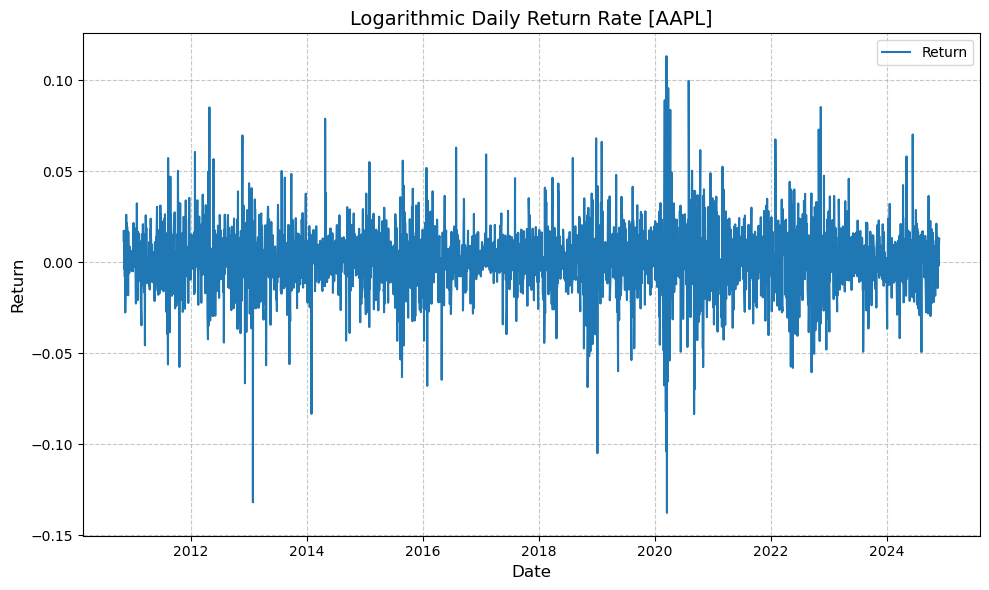

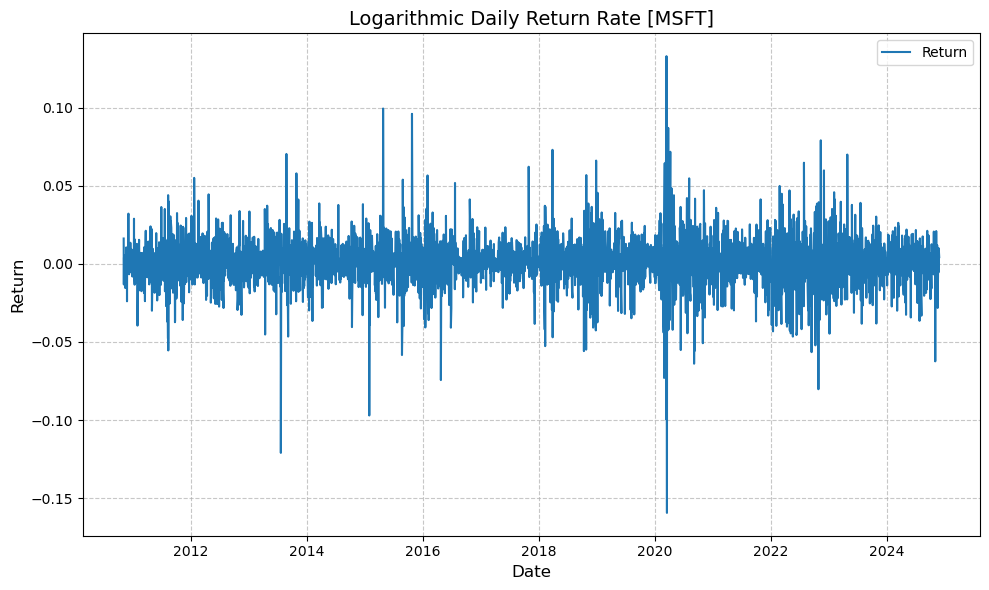

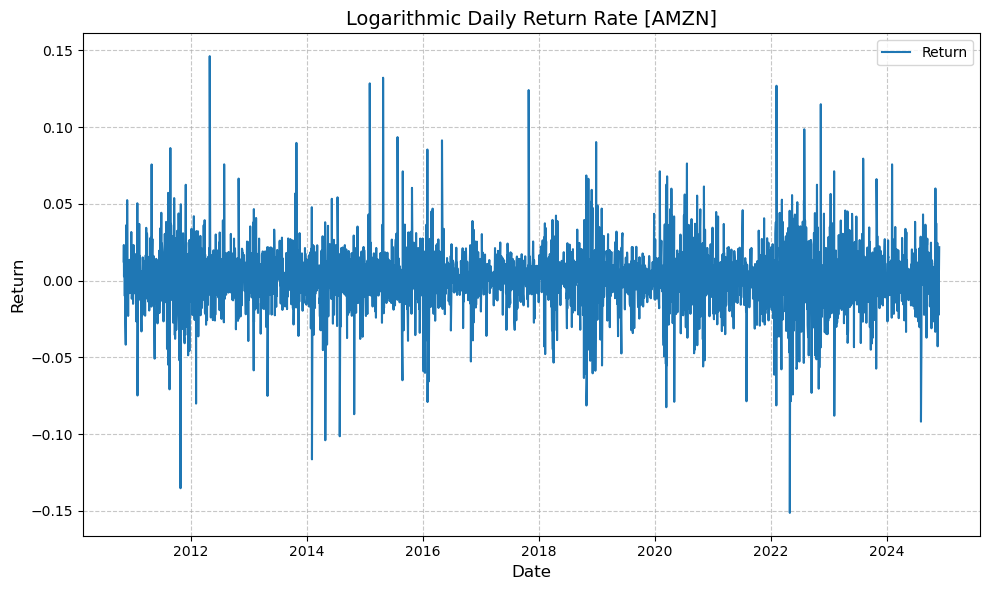

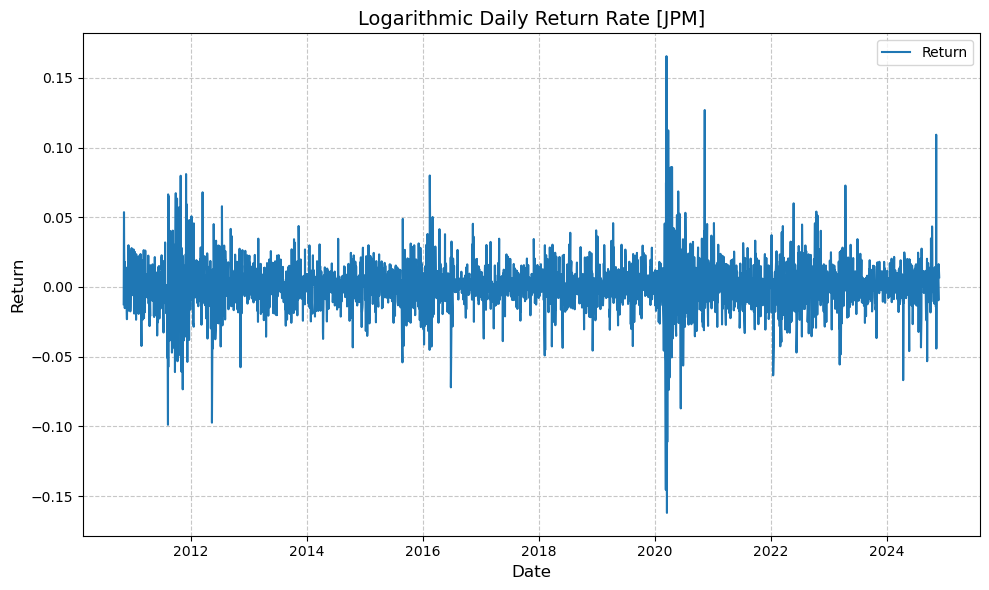

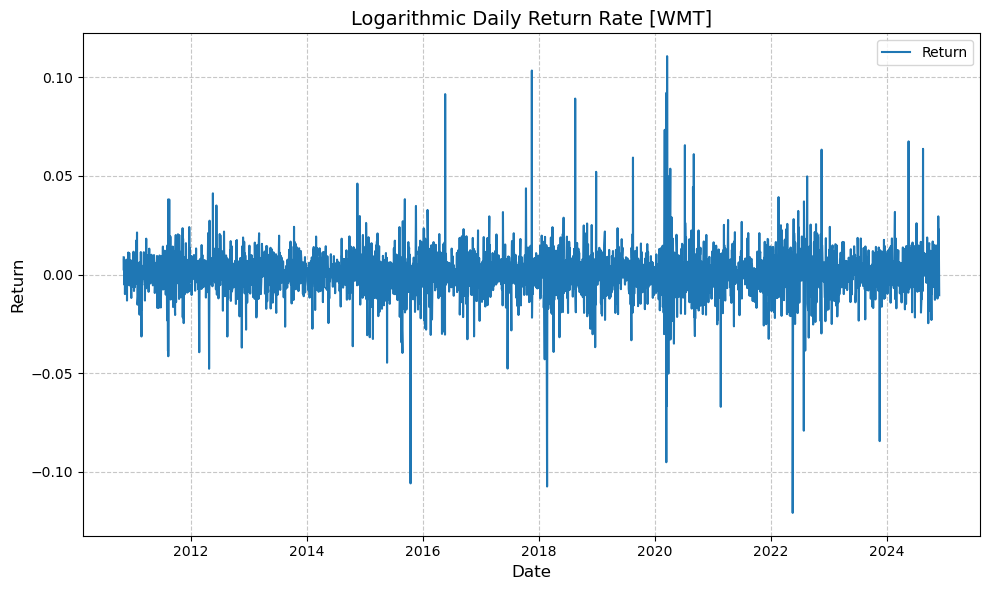

In [10]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker in tickers:
    plot_ret_rate(log_daily_ret_rates[ticker], "Logarithmic Daily Return Rate [" + ticker + "]")

### Tassi di rendimento settimanali

In [11]:
weekly_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Week"] = ret["Date"].dt.to_period("W")
    ret = ret.groupby("Week").first().reset_index()
    p_t = stock["Adj Close"].shift(-1)[:-1]
    p_t_1 = stock["Adj Close"][:-1] 
    ret[ticker] = (p_t - p_t_1)/p_t_1
    ret.set_index("Date", inplace=True)
    weekly_ret_rates = pd.concat([weekly_ret_rates, ret[ticker]], axis=1)
weekly_ret_rates.to_csv("weekly_ret_rates.csv")
print(weekly_ret_rates)

                         AAPL      MSFT      AMZN       JPM       WMT
2010-11-02 00:00:00  0.017029  0.016326  0.012486 -0.012293  0.008838
2010-11-08 00:00:00  0.011120 -0.013144  0.023449  0.020563  0.002190
2010-11-15 00:00:00  0.017487  0.004070  0.002730  0.055143  0.008195
2010-11-22 00:00:00 -0.003582 -0.010685  0.010892  0.028643 -0.002890
2010-11-29 00:00:00  0.004698 -0.001490  0.007144 -0.010503 -0.005254
...                       ...       ...       ...       ...       ...
2024-10-28 00:00:00 -0.007137  0.015258 -0.006633  0.006745 -0.003484
2024-11-04 00:00:00 -0.012428  0.000300 -0.010664 -0.010528 -0.005379
2024-11-11 00:00:00  0.023513  0.009014  0.026580  0.005224 -0.005002
2024-11-18 00:00:00  0.003279  0.010125 -0.001371  0.009888  0.001766
2024-11-25 00:00:00 -0.012562 -0.001769 -0.017940 -0.002880 -0.007596

[735 rows x 5 columns]


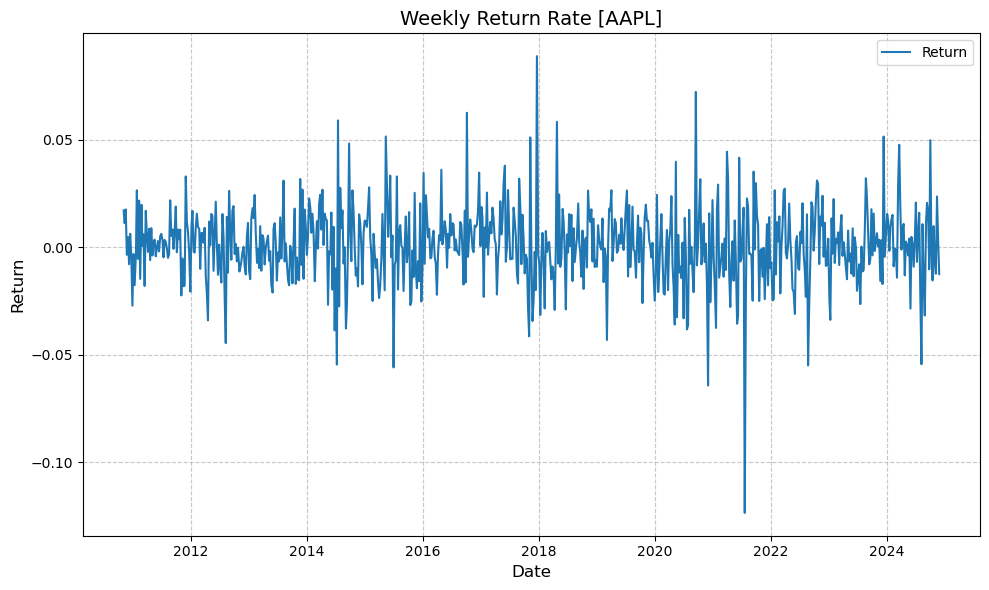

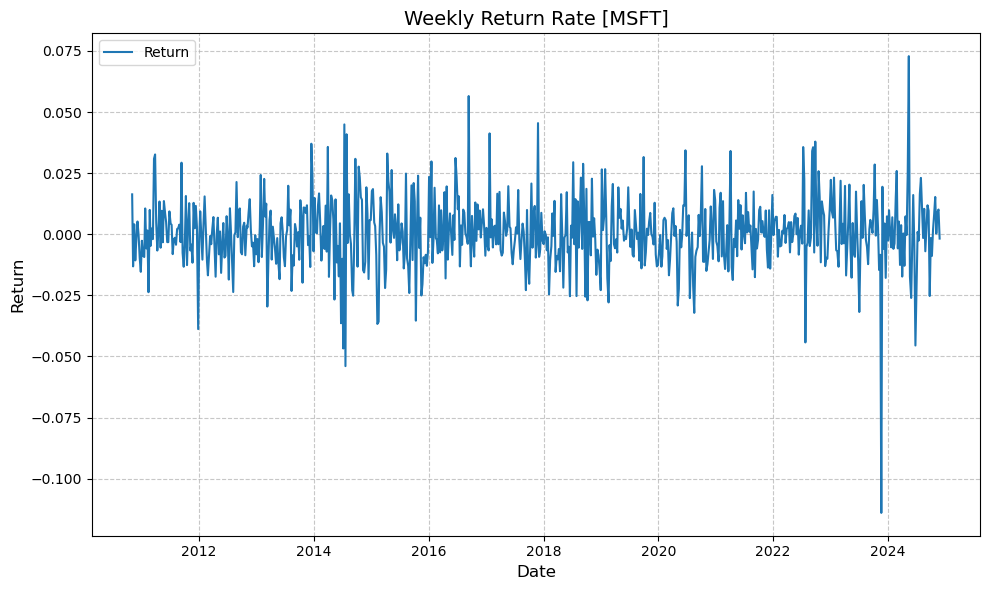

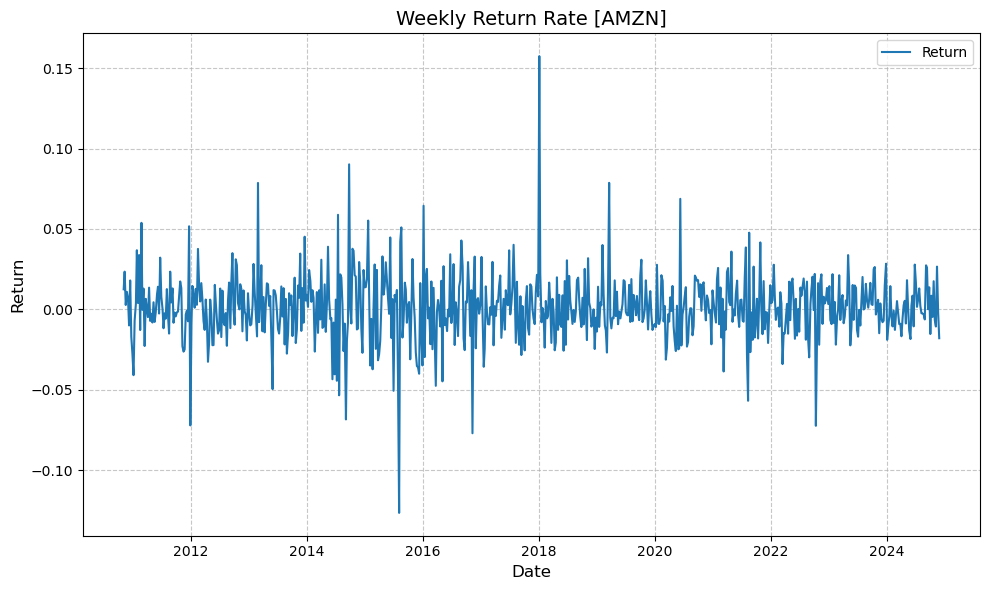

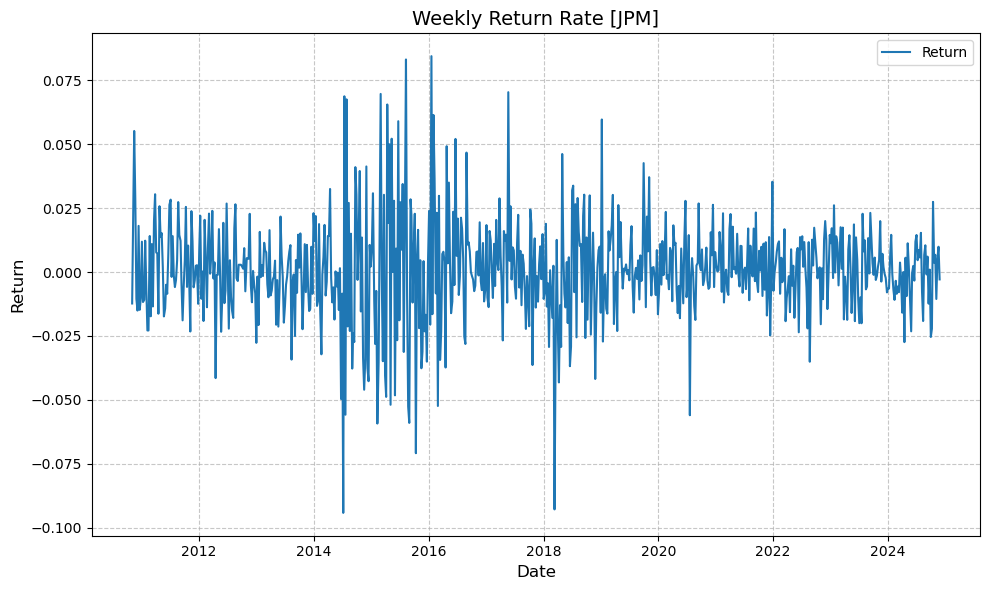

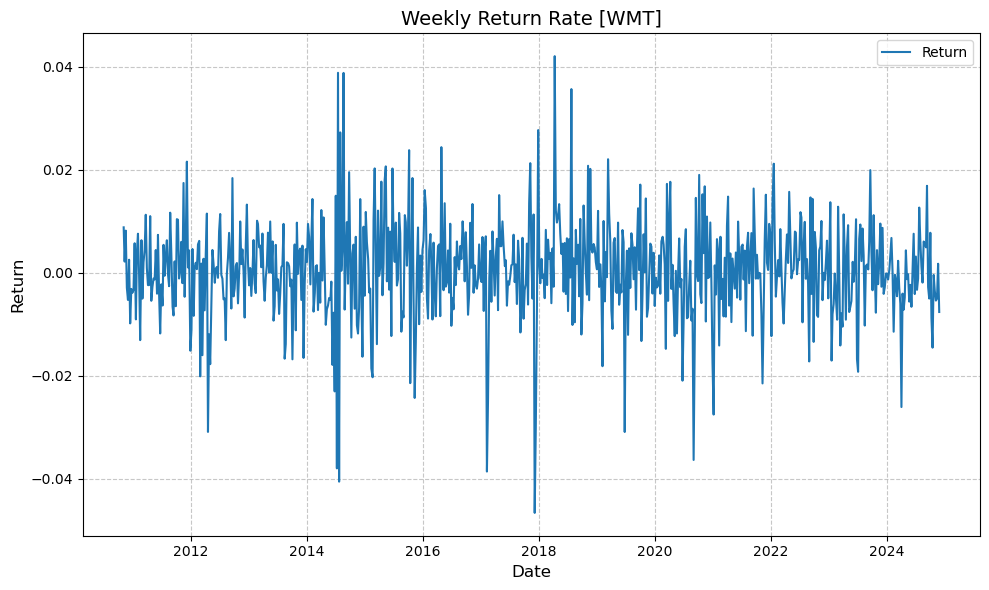

In [12]:
# Faccio il grafico di tutti i ritorni per ogni stock
for ticker in tickers:
    plot_ret_rate(weekly_ret_rates[ticker], "Weekly Return Rate [" + ticker + "]")

### Tassi di rendimento mensili

In [13]:
monthly_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Month"] = ret["Date"].dt.to_period("M")
    ret = ret.groupby("Month").first().reset_index()
    p_t = stock["Adj Close"].shift(-1)[:-1]
    p_t_1 = stock["Adj Close"][:-1] 
    ret[ticker] = ((p_t - p_t_1)/p_t_1)
    ret.set_index("Date", inplace=True)
    monthly_ret_rates = pd.concat([monthly_ret_rates, ret[ticker]], axis=1)

print(monthly_ret_rates)

                         AAPL      MSFT      AMZN       JPM       WMT
2010-11-02 00:00:00  0.017029  0.016326  0.012486 -0.012293  0.008838
2010-12-01 00:00:00  0.011120 -0.013144  0.023449  0.020563  0.002190
2011-01-03 00:00:00  0.017487  0.004070  0.002730  0.055143  0.008195
2011-02-01 00:00:00 -0.003582 -0.010685  0.010892  0.028643 -0.002890
2011-03-01 00:00:00  0.004698 -0.001490  0.007144 -0.010503 -0.005254
...                       ...       ...       ...       ...       ...
2024-07-01 00:00:00  0.009698  0.023809  0.005466 -0.008526  0.004589
2024-08-01 00:00:00 -0.003639 -0.006976  0.009044  0.023015  0.002094
2024-09-03 00:00:00  0.004880  0.014832  0.001518  0.012114  0.009498
2024-10-01 00:00:00  0.022611  0.000769  0.024451  0.021873  0.006963
2024-11-01 00:00:00  0.017975  0.000385  0.017662 -0.013228 -0.002242

[169 rows x 5 columns]


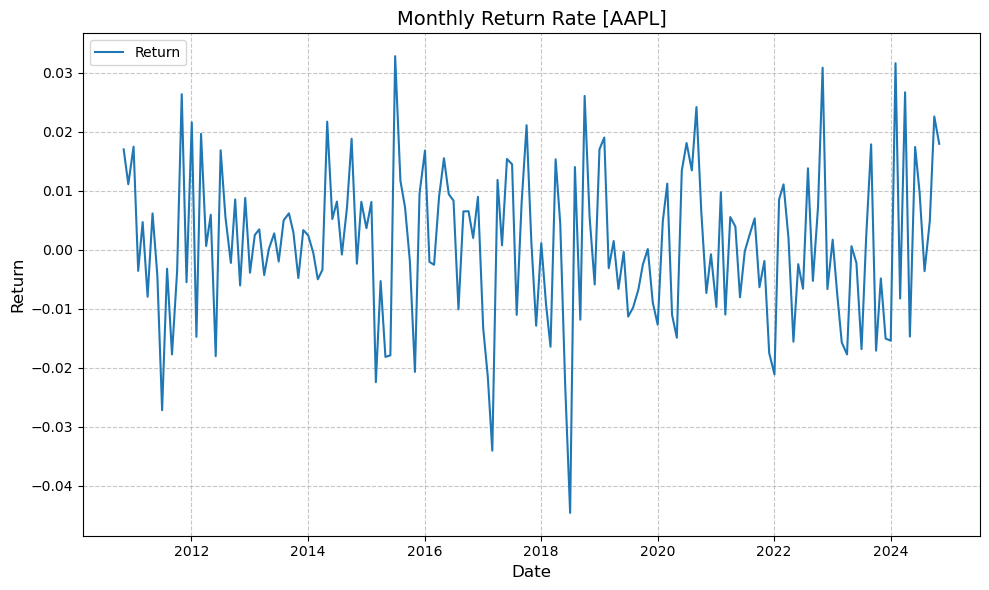

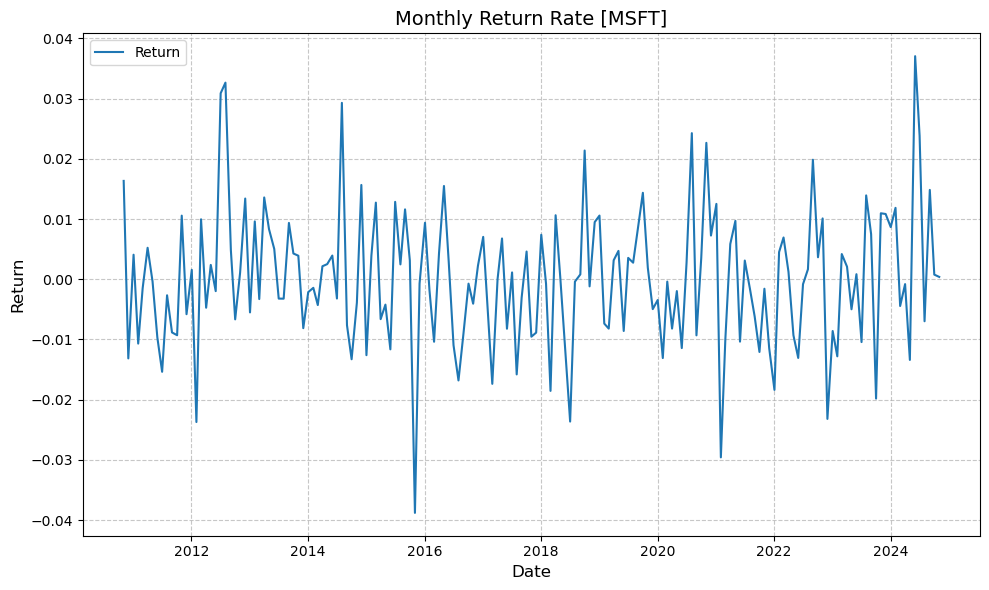

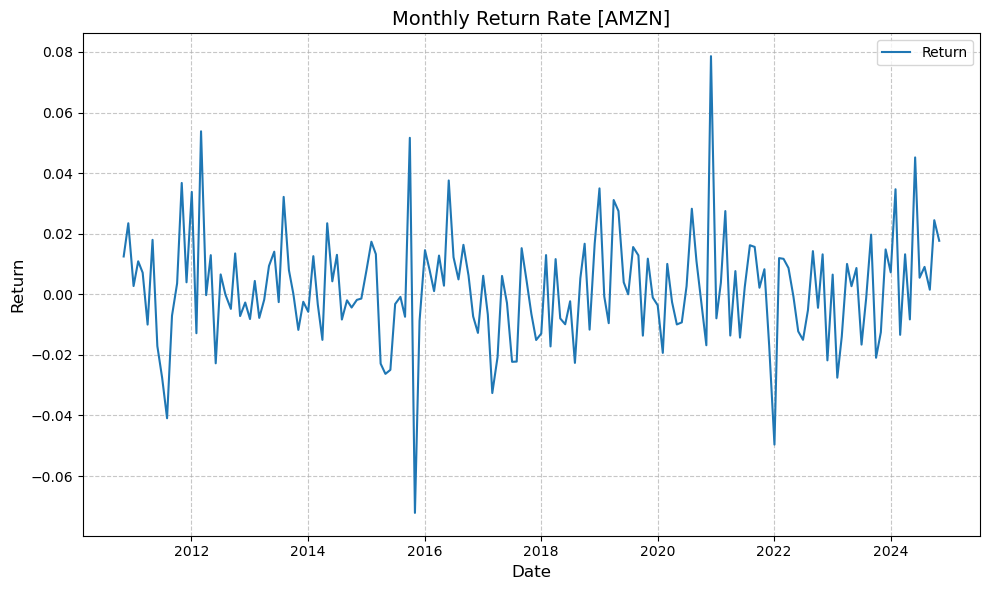

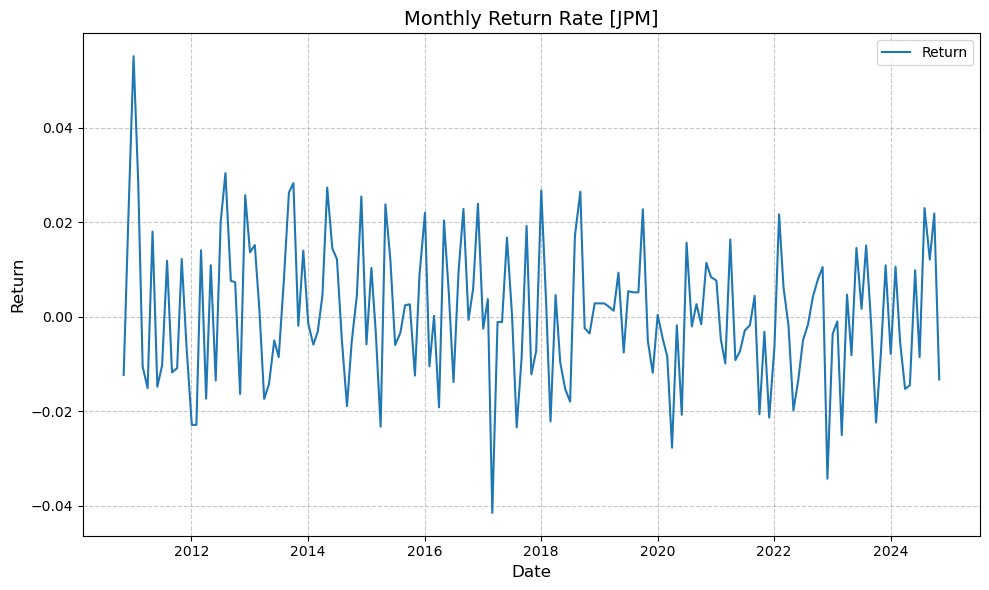

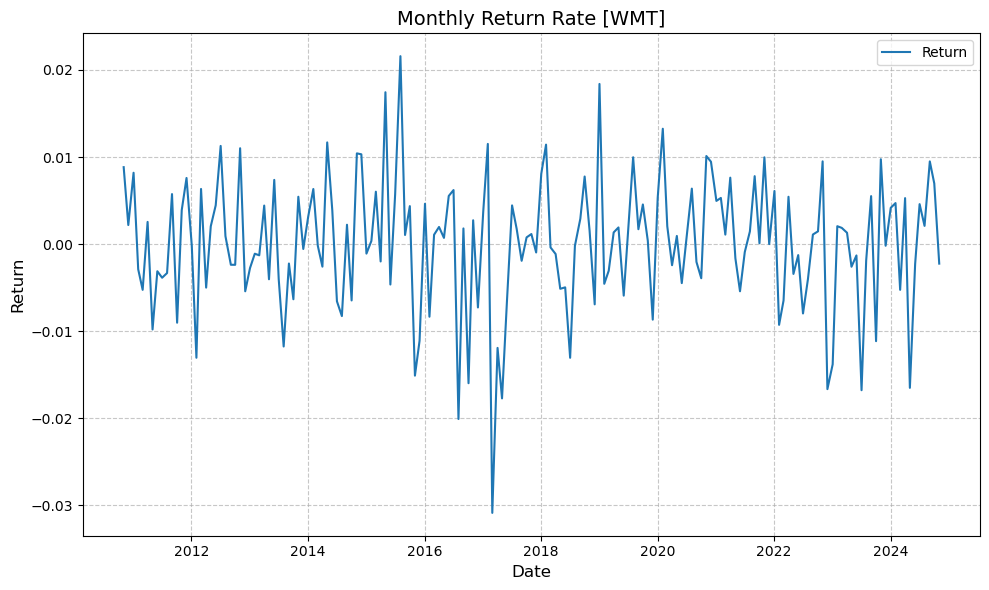

In [14]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in monthly_ret_rates.items():
    plot_ret_rate(ret, "Monthly Return Rate [" + ticker + "]")

## Frontiera efficiente

### Matrice Varianza-Covarianza

In [15]:
# Unisco i dati delle varie stock in un unico dataframe
all_stocks = pd.DataFrame()
for ticker, stock in stocks.items():
    df = pd.DataFrame()
    df = stock.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df = df.rename(columns={"Adj Close": ticker})
    
    all_stocks = pd.concat([all_stocks, df[ticker]], axis=1)

all_stocks.dropna(inplace=True)
#print(all_stocks.cov())

all_stocks_weekly = all_stocks.copy()
all_stocks_weekly.dropna(inplace=True)
all_stocks_weekly["Date"] = all_stocks_weekly.index.astype(str)
all_stocks_weekly["Date"] = pd.to_datetime(all_stocks_weekly["Date"])
all_stocks_weekly["Date"] = all_stocks_weekly["Date"].dt.tz_localize(None)
all_stocks_weekly["Week"] = all_stocks_weekly["Date"].dt.to_period("W")
all_stocks_weekly = all_stocks_weekly.groupby("Week").first().reset_index()
all_stocks_weekly.set_index("Date", inplace=True)
all_stocks_weekly.drop(columns=["Week"], inplace=True)

all_stocks_weekly.to_csv("all_stocks_weekly.csv")

all_stocks_monthly = all_stocks.copy()
all_stocks_monthly.dropna(inplace=True)
all_stocks_monthly["Date"] = all_stocks_monthly.index.astype(str)
all_stocks_monthly["Date"] = pd.to_datetime(all_stocks_monthly["Date"])
all_stocks_monthly["Date"] = all_stocks_monthly["Date"].dt.tz_localize(None)
all_stocks_monthly["Month"] = all_stocks_monthly["Date"].dt.to_period("M")
all_stocks_monthly = all_stocks_monthly.groupby("Month").first().reset_index()
all_stocks_monthly.set_index("Date", inplace=True)
all_stocks_monthly.drop(columns=["Month"], inplace=True)

# Costruisco la matrice di covarianza
#print(all_stocks_weekly.cov())
#print(all_stocks_monthly.cov())

#print(np.sqrt(all_stocks.cov()))
#print(np.sqrt(all_stocks_weekly.cov()))
#print(np.sqrt(all_stocks_monthly.cov()))

eigenvalues = np.linalg.eigvals(all_stocks.cov())
print(eigenvalues)
if np.any(eigenvalues < 0):
    print("La matrice di covarianza non è semidefinita positiva.")

[2.50302128e+04 4.51891464e+02 1.79214900e+02 7.14970170e+01
 1.07956581e+01]


### Tassi di rendimento per le stock

In [16]:
# Calcolo del tasso di rendimento per ogni stock
stock_exp_daily_return = pd.DataFrame()
stock_exp_weekly_return = pd.DataFrame()
stock_exp_monthly_return = pd.DataFrame()

# Calcolo il tasso di rendimento medio
stock_exp_daily_return["Return"] = (np.log(all_stocks.iloc[-1]) - np.log(all_stocks.iloc[0])) / len(all_stocks)
stock_exp_weekly_return["Return"] = weekly_ret_rates.mean()
stock_exp_monthly_return["Return"] = monthly_ret_rates.mean()

print(stock_exp_daily_return)
print(stock_exp_weekly_return)
print(stock_exp_monthly_return)

        Return
AAPL  0.000914
MSFT  0.000851
AMZN  0.000907
JPM   0.000644
WMT   0.000537
        Return
AAPL  0.000827
MSFT  0.000527
AMZN  0.001109
JPM   0.000747
WMT   0.000554
        Return
AAPL  0.000906
MSFT -0.000031
AMZN  0.001772
JPM   0.000728
WMT   0.000040


### Insieme dei portafogli fattibili

In [17]:
# Creo un dataframe in cui faccio variare la combinazione dei pesi delle azioni
wallets = pd.DataFrame()
# creo una colonna per ogni peso
for ticker in tickers:
    # faccio 100 estrazioni casuali tra 0 e 1
    #wallets[ticker] = np.random.uniform(-100000, 100000, 10000)
    wallets[ticker] = np.random.normal(0, 10000, 100000)

# Normalizzo i pesi
wallets = wallets.div(wallets.sum(axis=1), axis=0)

# Calcolo il rendimento atteso pesando i rendimenti delle azioni per i pesi
wallets_daily_return = (wallets * stock_exp_daily_return["Return"]).sum(axis=1)
wallets_weekly_return = (wallets * stock_exp_weekly_return["Return"]).sum(axis=1)
wallets_monthly_return = (wallets * stock_exp_monthly_return["Return"]).sum(axis=1)

# Calcolo la varianza pesata
daily_cov = log_daily_ret_rates.cov()
monthly_cov = monthly_ret_rates.cov()
weekly_cov = weekly_ret_rates.cov()
#print(cov)
wallets_daily_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(daily_cov, x))), axis=1)
wallets_weekly_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(weekly_cov, x))), axis=1)
wallets_monthly_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(monthly_cov, x))), axis=1)


# Unisco i dati in un unico dataframe
wallets["Daily_Return"] = wallets_daily_return
wallets["Weekly_Return"] = wallets_weekly_return
wallets["Monthly_Return"] = wallets_monthly_return
wallets["Daily_Risk"] = wallets_daily_variance
wallets["Weekly_Risk"] = wallets_weekly_variance
wallets["Monthly_Risk"] = wallets_monthly_variance
print(wallets.head)


<bound method NDFrame.head of            AAPL      MSFT      AMZN       JPM       WMT  Daily_Return  \
0      1.229891  1.314187 -0.396994  0.937681 -2.084765      0.001366   
1      0.602832  0.838553  0.285493 -0.021925 -0.704953      0.001130   
2     -0.499621 -0.207911  0.810479 -0.266047  1.163101      0.000555   
3      1.173147  0.233565 -1.266340 -0.384761  1.244388      0.000543   
4      0.536290  0.542240  0.163287  0.175096 -0.416914      0.000988   
...         ...       ...       ...       ...       ...           ...   
99995  0.133755 -0.924952  0.977763  0.803071  0.010363      0.000745   
99996  0.743998  0.490008  0.153059 -0.205161 -0.181905      0.001006   
99997  0.454987 -0.231759  1.065210 -0.021475 -0.266964      0.001027   
99998 -0.528153  0.086026  1.317793  0.121140  0.003194      0.000865   
99999  0.059546  0.657716  1.160846 -0.689553 -0.188555      0.001121   

       Weekly_Return  Monthly_Return  Daily_Risk  Weekly_Risk  Monthly_Risk  
0           0.0

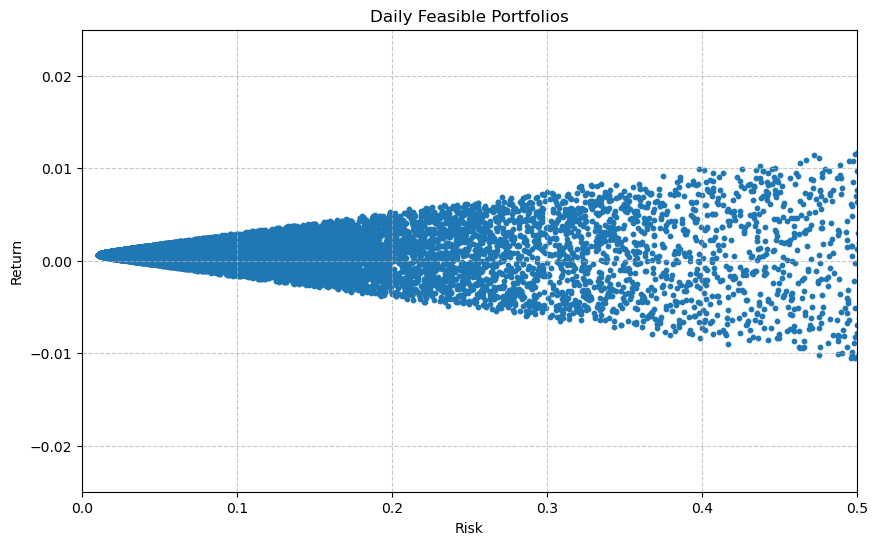

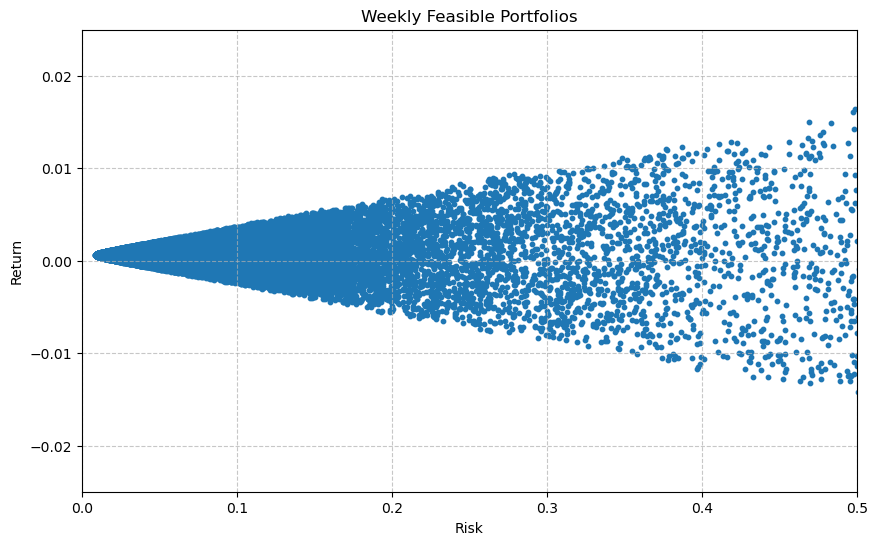

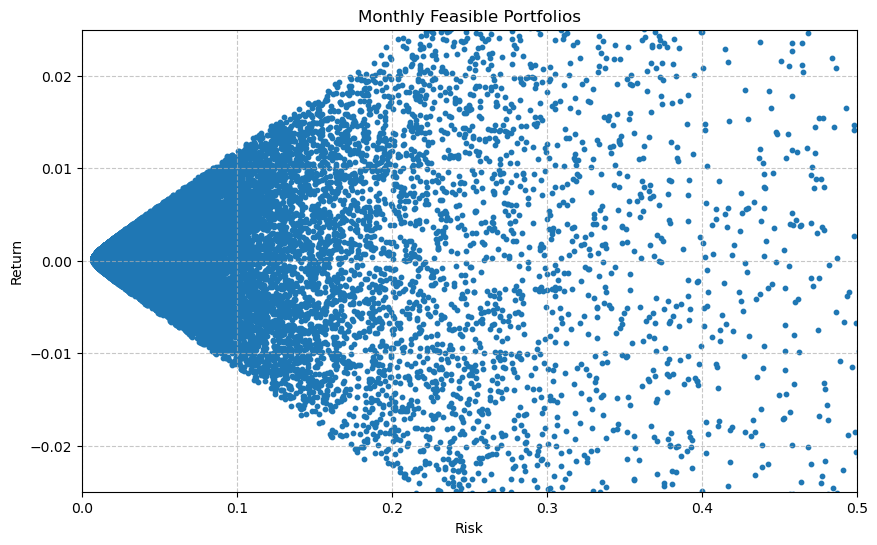

In [18]:
# Grafico i vari portafogli con uno scatter plot
def plot_feasible_wallets(risk, exp_ret, title, x_lim = None, y_lim = None):
    plt.figure(figsize=(10, 6))
    plt.scatter(risk, exp_ret, alpha=1, s=10)
    plt.title(title)
    plt.xlabel("Risk")
    plt.ylabel("Return")
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)

    plt.grid(True, linestyle='--', alpha=0.7)
    # Scala logaritmica
    #plt.xscale("log")
    plt.savefig(f"docs/images/{title}.png")
    plt.show()

plot_feasible_wallets(wallets["Daily_Risk"], wallets["Daily_Return"] , "Daily Feasible Portfolios", x_lim=(0, 0.5), y_lim=(-0.025, 0.025))
plot_feasible_wallets(wallets["Weekly_Risk"], wallets["Weekly_Return"] , "Weekly Feasible Portfolios", x_lim=(0, 0.5), y_lim=(-0.025, 0.025))
plot_feasible_wallets(wallets["Monthly_Risk"], wallets["Monthly_Return"] , "Monthly Feasible Portfolios", x_lim=(0, 0.5), y_lim=(-0.025, 0.025))

### No risk return

In [19]:
no_risk_ret = pd.read_csv("no_risk_return_1m.csv", )


# Prendo solo l'intervallo considerato
no_risk_ret = no_risk_ret[(no_risk_ret["Date"] >= start_date_str) & (no_risk_ret["Date"] <= end_date_str)]

no_risk_ret_mean_monthly = no_risk_ret["Return"].mean() /100
no_risk_ret_mean_weekly = ((1 + no_risk_ret_mean_monthly) ** (1/4) - 1) /100
no_risk_ret_mean_daily = ((1 + no_risk_ret_mean_monthly) ** (1/30) - 1)/100



print(no_risk_ret_mean_monthly)
print(no_risk_ret_mean_weekly)
print(no_risk_ret_mean_daily)

-0.0019258041247706432
-4.8179911494661276e-06
-6.425329799297775e-07


### Frontiera


In [20]:
from scipy.optimize import minimize

def objective_function(weights, cov):
    if(np.dot(weights, np.dot(cov, weights)) < 0):
        print(weights)
        print(cov)
        print("Valore negativo" + str((np.dot(weights, np.dot(cov, weights)))))
    return np.sqrt(np.dot(weights, np.dot(cov, weights)))

initial_weights = np.array([1/len(tickers)]*len(tickers))

def constraint_sum_to_one(params):
    return np.sum(params) - 1

def constraint_return_rate(params, exp_ret, return_rate):
    return np.dot(params, exp_ret) - return_rate

def efficient_frontier(exp_ret, cov, range = 0.02, step = 0.00005):
    min_walltes = pd.DataFrame()
    for i in np.arange(0, range, step):
        constraints = [
            {'type': 'eq', 'fun': constraint_sum_to_one},
            {'type': 'eq', 'fun': constraint_return_rate, 'args': (exp_ret, i)}
        ]

        result = minimize(objective_function, initial_weights, args=(cov, ), constraints=constraints)
        if not result.success:
            print(f"Errore nell'ottimizzazione: {result.message}")
            continue
        # Aggiungo la coppia rischio rendimento al dataframe
        new_r = pd.DataFrame([[i, result.fun]], columns=["Return", "Risk"])
        min_walltes = pd.concat([min_walltes, new_r], axis=0)

    return min_walltes

daily_efficient_frontier = efficient_frontier(stock_exp_daily_return["Return"], daily_cov).dropna()
weekly_efficient_frontier = efficient_frontier(stock_exp_weekly_return["Return"], weekly_cov).dropna()
monthly_efficient_frontier = efficient_frontier(stock_exp_monthly_return["Return"], monthly_cov).dropna()


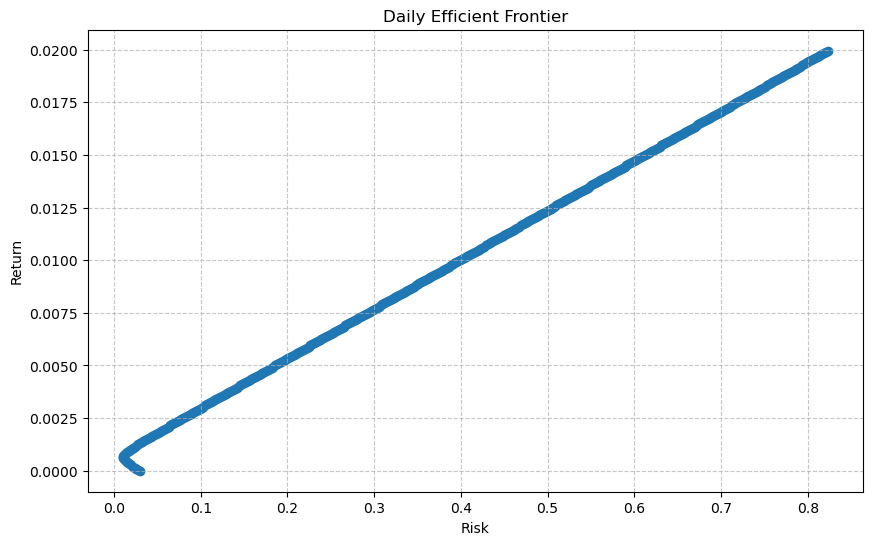

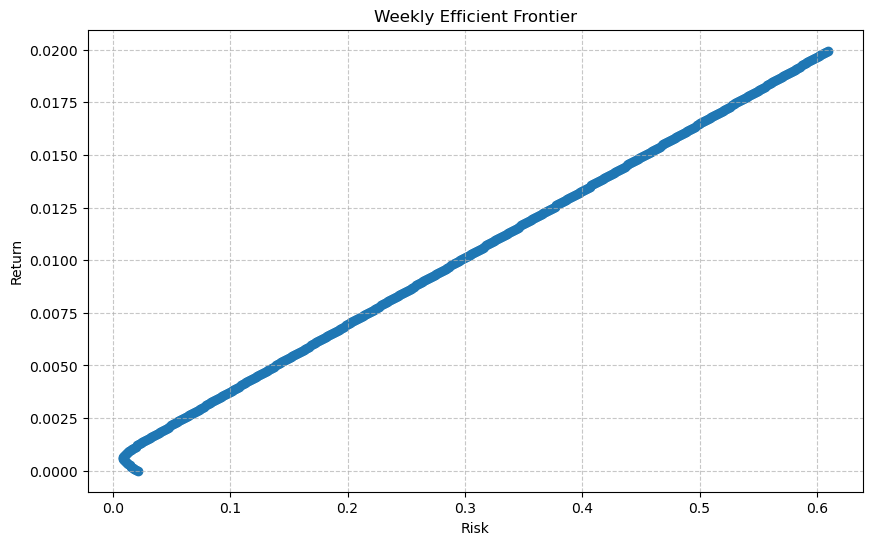

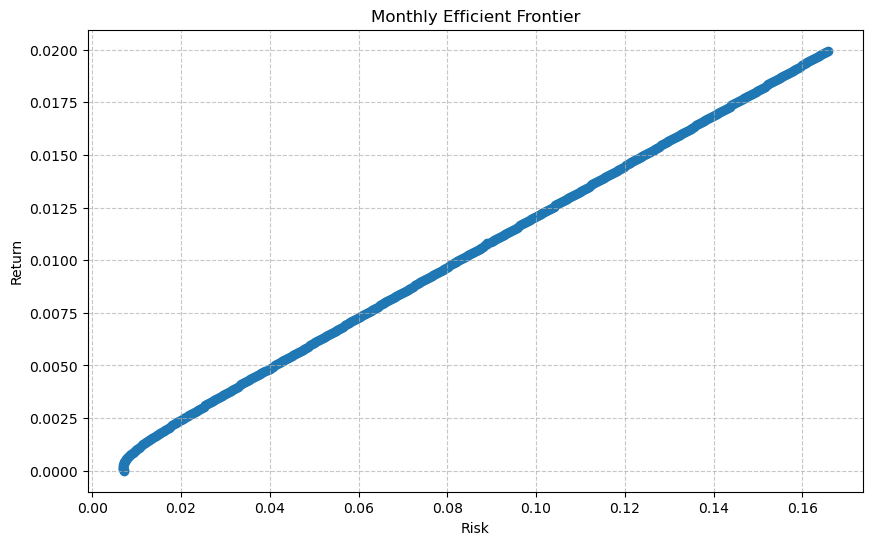

In [21]:
def plot_efficient_frontier(data, title, x_lim = None, y_lim = None): 
    plt.figure(figsize=(10, 6))
    plt.scatter(data["Risk"], data["Return"], alpha=1)
    plt.title(title)
    plt.xlabel("Risk")
    plt.ylabel("Return")
    if x_lim is not None: plt.xlim(0, x_lim)
    if y_lim is not None: plt.ylim(0, y_lim)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"docs/images/{title}.png")
    plt.show()

#plot_efficient_frontier(daily_efficient_frontier, "Daily Efficient Frontier", 0.5, 0.015)
#plot_efficient_frontier(weekly_efficient_frontier, "Weekly Efficient Frontier", 0.5, 0.015)
#plot_efficient_frontier(monthly_efficient_frontier, "Monthly Efficient Frontier", 0.5, 0.015)
plot_efficient_frontier(daily_efficient_frontier, "Daily Efficient Frontier")
plot_efficient_frontier(weekly_efficient_frontier, "Weekly Efficient Frontier")
plot_efficient_frontier(monthly_efficient_frontier, "Monthly Efficient Frontier")

### Tangente

In [22]:

teta = np.arctan((daily_efficient_frontier["Return"] - no_risk_ret_mean_daily) / (daily_efficient_frontier["Risk"]))
print(teta.max())   
teta_max_daily = teta.max()
teta = np.arctan((weekly_efficient_frontier["Return"] - no_risk_ret_mean_weekly) / (weekly_efficient_frontier["Risk"]))
print(teta.max())
teta_max_weekly = teta.max()
teta = np.arctan((monthly_efficient_frontier["Return"] - no_risk_ret_mean_monthly) / (monthly_efficient_frontier["Risk"]))
print(teta.max())
teta_max_monthly = teta.max()

tang_p_daily = []
tang_p_weekly = []
tang_p_monthly = []
# Costruisco la retta tangente a partire dall'angolo teta e dal rendimento senza rischio
for x in np.arange(0, 0.5, 0.0001):
    y_daily = no_risk_ret_mean_daily + x * np.tan(teta_max_daily)
    y_weekly = no_risk_ret_mean_weekly + x * np.tan(teta_max_weekly)
    y_monthly = no_risk_ret_mean_monthly + x * np.tan(teta_max_monthly)
    tang_p_daily.append([x, y_daily])
    tang_p_weekly.append([x, y_weekly])
    tang_p_monthly.append([x, y_monthly])

pd_tang_daily = pd.DataFrame(tang_p_daily, columns=["Risk", "Return"])
pd_tang_weekly = pd.DataFrame(tang_p_weekly, columns=["Risk", "Return"])
pd_tang_monthly = pd.DataFrame(tang_p_monthly, columns=["Risk", "Return"])



0.06501413664464349
0.076462052654222
0.3114522438438599


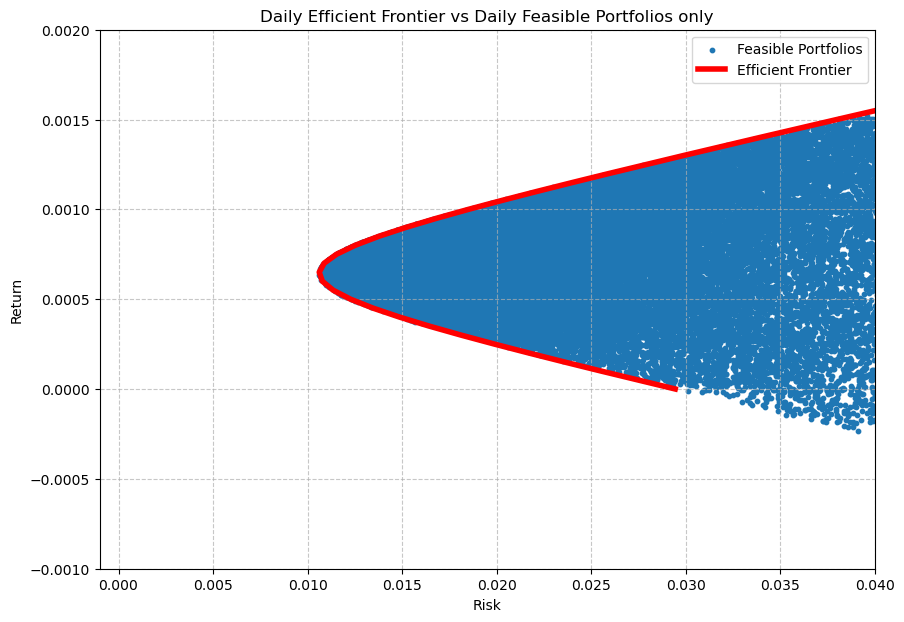

In [23]:
# Unisco i due grafici

def plot_efficient_frontier_vs_feasible2(data, 
                                        feasible_risk, 
                                        feasible_return, 
                                        no_risk_ret, 
                                        pd_tang,
                                        title, 
                                        x_lim = None, 
                                        y_lim = None):
    plt.figure(figsize=(10, 7))
    plt.scatter(feasible_risk, feasible_return, alpha=1, label="Feasible Portfolios", s=10)
    #plt.scatter(0, no_risk_ret, alpha=1, label="No Risk Return", s=50, color="green")
    plt.plot(data["Risk"], data["Return"], alpha=1, label="Efficient Frontier", color="red", linewidth=4)
    #plt.plot(pd_tang["Risk"], pd_tang["Return"], alpha=1, label="Tangent Line", color="blue", linestyle="--")
    plt.title(title)
    plt.xlabel("Risk")
    plt.ylabel("Return")
    if x_lim is not None: plt.xlim(-0.001, x_lim)
    if y_lim is not None: plt.ylim(no_risk_ret - 0.001, y_lim)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.savefig(f"docs/images/{title}.png")
    plt.show()
plot_efficient_frontier_vs_feasible2(daily_efficient_frontier,
                                    wallets["Daily_Risk"],
                                    wallets["Daily_Return"], 
                                    no_risk_ret_mean_daily,
                                    pd_tang_daily,
                                    "Daily Efficient Frontier vs Daily Feasible Portfolios only", 
                                    x_lim = 0.04, 
                                    y_lim = 0.002)

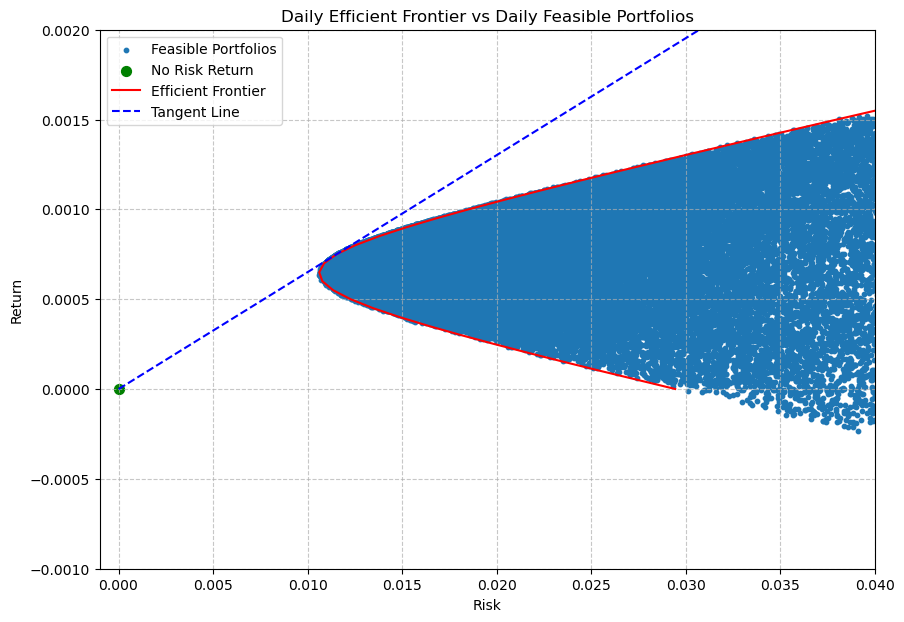

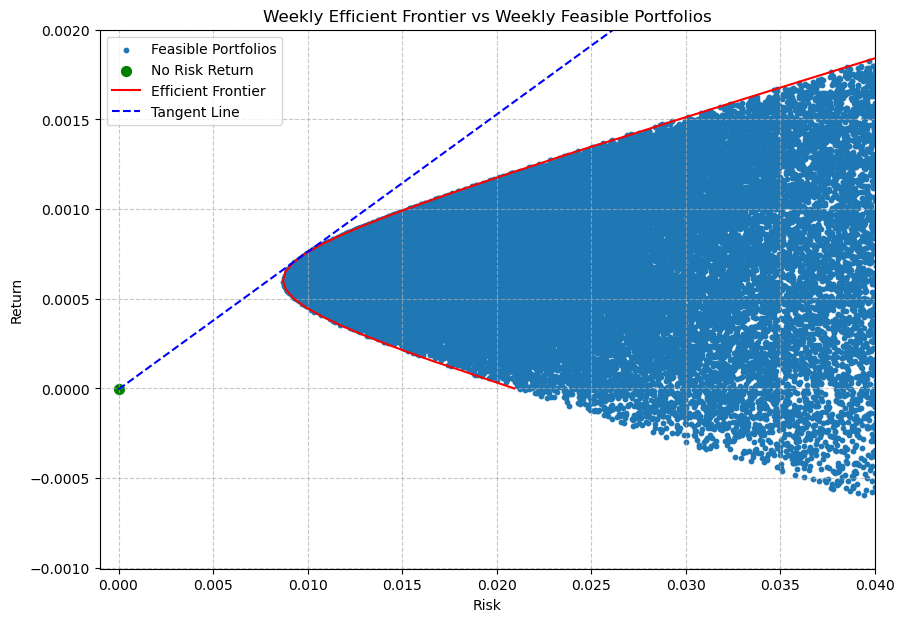

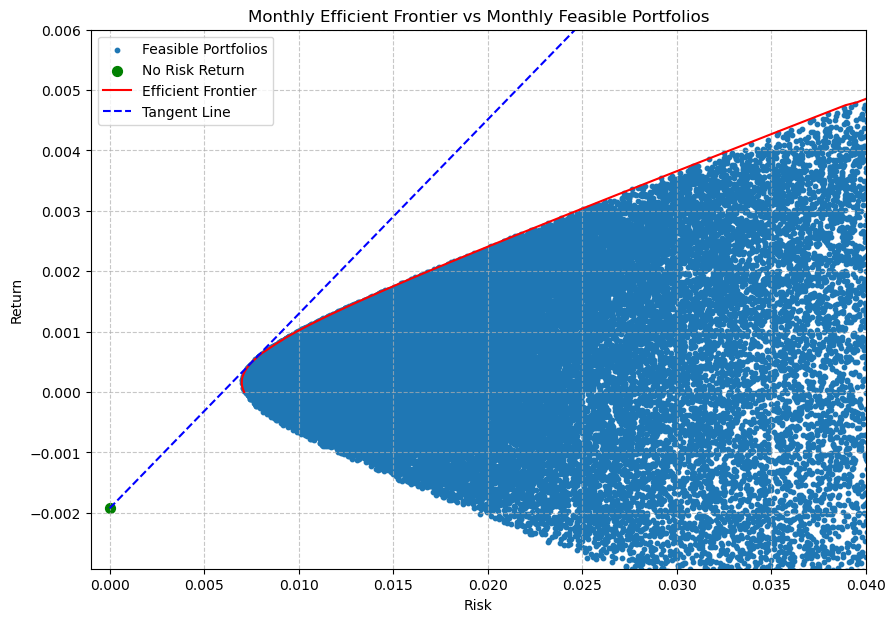

In [24]:
# Unisco i due grafici

def plot_efficient_frontier_vs_feasible(data, 
                                        feasible_risk, 
                                        feasible_return, 
                                        no_risk_ret, 
                                        pd_tang,
                                        title, 
                                        x_lim = None, 
                                        y_lim = None):
    plt.figure(figsize=(10, 7))
    plt.scatter(feasible_risk, feasible_return, alpha=1, label="Feasible Portfolios", s=10)
    plt.scatter(0, no_risk_ret, alpha=1, label="No Risk Return", s=50, color="green")
    plt.plot(data["Risk"], data["Return"], alpha=1, label="Efficient Frontier", color="red")
    plt.plot(pd_tang["Risk"], pd_tang["Return"], alpha=1, label="Tangent Line", color="blue", linestyle="--")
    plt.title(title)
    plt.xlabel("Risk")
    plt.ylabel("Return")
    if x_lim is not None: plt.xlim(-0.001, x_lim)
    if y_lim is not None: plt.ylim(no_risk_ret - 0.001, y_lim)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.savefig(f"docs/images/{title}.png")
    plt.show()
plot_efficient_frontier_vs_feasible(daily_efficient_frontier,
                                    wallets["Daily_Risk"],
                                    wallets["Daily_Return"], 
                                    no_risk_ret_mean_daily,
                                    pd_tang_daily,
                                    "Daily Efficient Frontier vs Daily Feasible Portfolios", 
                                    x_lim = 0.04, 
                                    y_lim = 0.002)

plot_efficient_frontier_vs_feasible(weekly_efficient_frontier,
                                    wallets["Weekly_Risk"],
                                    wallets["Weekly_Return"], 
                                    no_risk_ret_mean_weekly,
                                    pd_tang_weekly,
                                    "Weekly Efficient Frontier vs Weekly Feasible Portfolios", 
                                    x_lim = 0.04, 
                                    y_lim = 0.002)

plot_efficient_frontier_vs_feasible(monthly_efficient_frontier,
                                    wallets["Monthly_Risk"],
                                    wallets["Monthly_Return"], 
                                    no_risk_ret_mean_monthly,
                                    pd_tang_monthly,
                                    "Monthly Efficient Frontier vs Monthly Feasible Portfolios", 
                                    x_lim = 0.04, 
                                    y_lim = 0.006)

### Insieme dei portafogli fattibili con rendimento privo di rischio

In [25]:
# Aggiorno la matrice varianza covarianza aggiungendo una colonna 
daily_cov_with_bond = daily_cov.copy()
daily_cov_with_bond["NoRisk"] = 0
daily_cov_with_bond.loc["NoRisk"] = 0
print(daily_cov_with_bond)

weekly_cov_with_bond = weekly_cov.copy()
weekly_cov_with_bond["NoRisk"] = 0
weekly_cov_with_bond.loc["NoRisk"] = 0
print(weekly_cov_with_bond)

monthly_cov_with_bond = monthly_cov.copy()
monthly_cov_with_bond["NoRisk"] = 0
monthly_cov_with_bond.loc["NoRisk"] = 0
print(monthly_cov_with_bond)

            AAPL      MSFT      AMZN       JPM       WMT  NoRisk
AAPL    0.000309  0.000169  0.000173  0.000118  0.000061       0
MSFT    0.000169  0.000263  0.000191  0.000126  0.000066       0
AMZN    0.000173  0.000191  0.000422  0.000109  0.000061       0
JPM     0.000118  0.000126  0.000109  0.000302  0.000057       0
WMT     0.000061  0.000066  0.000061  0.000057  0.000150       0
NoRisk  0.000000  0.000000  0.000000  0.000000  0.000000       0
            AAPL      MSFT      AMZN       JPM       WMT  NoRisk
AAPL    0.000316  0.000083  0.000111  0.000109  0.000032       0
MSFT    0.000083  0.000208  0.000105  0.000135  0.000046       0
AMZN    0.000111  0.000105  0.000421  0.000134  0.000042       0
JPM     0.000109  0.000135  0.000134  0.000389  0.000067       0
WMT     0.000032  0.000046  0.000042  0.000067  0.000091       0
NoRisk  0.000000  0.000000  0.000000  0.000000  0.000000       0
            AAPL      MSFT      AMZN       JPM       WMT  NoRisk
AAPL    0.000171  0.00006

In [26]:
# Aggiorno il vettore dei rendimenti attesi
stock_exp_daily_return_with_bond = stock_exp_daily_return.copy()
stock_exp_daily_return_with_bond.loc["Bond"] = no_risk_ret_mean_daily

stock_exp_weekly_return_with_bond = stock_exp_weekly_return.copy()
stock_exp_weekly_return_with_bond.loc["Bond"] = no_risk_ret_mean_weekly

stock_exp_monthly_return_with_bond = stock_exp_monthly_return.copy()
stock_exp_monthly_return_with_bond.loc["Bond"] = no_risk_ret_mean_monthly

print(stock_exp_daily_return_with_bond)
print(stock_exp_weekly_return_with_bond)
print(stock_exp_monthly_return_with_bond)

            Return
AAPL  9.136414e-04
MSFT  8.508299e-04
AMZN  9.065528e-04
JPM   6.443566e-04
WMT   5.371071e-04
Bond -6.425330e-07
        Return
AAPL  0.000827
MSFT  0.000527
AMZN  0.001109
JPM   0.000747
WMT   0.000554
Bond -0.000005
        Return
AAPL  0.000906
MSFT -0.000031
AMZN  0.001772
JPM   0.000728
WMT   0.000040
Bond -0.001926


In [27]:
# Creo un dataframe in cui faccio variare la combinazione dei pesi delle azioni
wallets_with_bond = pd.DataFrame()


# creo una colonna per ogni peso
for ticker in tickers:
    # faccio 100 estrazioni casuali tra 0 e 1
    #wallets[ticker] = np.random.uniform(-100000, 100000, 10000)
    wallets_with_bond[ticker] = np.random.normal(0, 10000, 10000)

# aggiungo una colonna per il peso dell'asset senza rischio
wallets_with_bond["Bond"] = np.random.normal(0, 10000, 10000)

# Normalizzo i pesi
wallets_with_bond = wallets_with_bond.div(wallets_with_bond.sum(axis=1), axis=0)
print(wallets_with_bond.loc[0])

# Calcolo il rendimento atteso pesando i rendimenti delle azioni per i pesi
wallets_daily_return_with_bond = (wallets_with_bond * stock_exp_daily_return_with_bond["Return"]).sum(axis=1)
wallets_weekly_return_with_bond = (wallets_with_bond * stock_exp_weekly_return_with_bond["Return"]).sum(axis=1)
wallets_monthly_return_with_bond = (wallets_with_bond * stock_exp_monthly_return_with_bond["Return"]).sum(axis=1)

print(wallets_daily_return_with_bond.loc[0])
print(wallets_weekly_return_with_bond.loc[0])
print(wallets_monthly_return_with_bond.loc[0])


#print(cov)
wallets_daily_variance_with_bond = wallets_with_bond.apply(lambda x: np.sqrt(np.dot(x, np.dot(daily_cov_with_bond, x))), axis=1)
wallets_weekly_variance_with_bond = wallets_with_bond.apply(lambda x: np.sqrt(np.dot(x, np.dot(weekly_cov_with_bond, x))), axis=1)
wallets_monthly_variance_with_bond = wallets_with_bond.apply(lambda x: np.sqrt(np.dot(x, np.dot(monthly_cov_with_bond, x))), axis=1)


# Unisco i dati in un unico dataframe
wallets_with_bond["Daily_Return"] = wallets_daily_return_with_bond
wallets_with_bond["Weekly_Return"] = wallets_weekly_return_with_bond
wallets_with_bond["Monthly_Return"] = wallets_monthly_return_with_bond
wallets_with_bond["Daily_Risk"] = wallets_daily_variance_with_bond
wallets_with_bond["Weekly_Risk"] = wallets_weekly_variance_with_bond
wallets_with_bond["Monthly_Risk"] = wallets_monthly_variance_with_bond
print(wallets_with_bond.head)


AAPL    0.046774
MSFT   -0.665369
AMZN    1.419434
JPM    -1.967752
WMT     2.368634
Bond   -0.201721
Name: 0, dtype: float64
0.0007678166712294005
0.0011038366398625073
0.0016310128447928045
<bound method NDFrame.head of           AAPL      MSFT      AMZN       JPM       WMT      Bond  \
0     0.046774 -0.665369  1.419434 -1.967752  2.368634 -0.201721   
1    -0.297612  0.208594  0.433241 -0.052550  0.200725  0.507601   
2    -0.119398  0.569581  0.298230 -0.015053  0.763672 -0.497031   
3     1.427248  0.833593 -0.843463 -1.678381  1.564248 -0.303244   
4    -0.350045  0.295739  0.891897 -0.440998  0.210440  0.392967   
...        ...       ...       ...       ...       ...       ...   
9995 -0.043161  0.226073  0.266707 -0.242637  0.507929  0.285088   
9996  1.485448  0.697706 -0.894025 -0.478425 -0.053929  0.243226   
9997 -0.135262  0.347785  0.475378 -0.097217  0.169420  0.239896   
9998 -0.200546  0.196098  0.538356  0.080922  0.560986 -0.175817   
9999 -0.204632  0.327315  0.60

In [28]:
#plot_feasible_wallets(wallets_with_bond["Daily_Risk"], wallets_with_bond["Daily_Return"] , "Daily Feasible Portfolios", x_lim=(0, 0.5), y_lim=(-0.025, 0.025))
#plot_feasible_wallets(wallets_with_bond["Weekly_Risk"], wallets_with_bond["Weekly_Return"] , "Weekly Feasible Portfolios", x_lim=(0, 0.5), y_lim=(-0.025, 0.025))
#plot_feasible_wallets(wallets_with_bond["Monthly_Risk"], wallets_with_bond["Monthly_Return"] , "Monthly Feasible Portfolios", x_lim=(0, 0.5), y_lim=(-0.025, 0.025))

### Portafoglio tangente

In [29]:
def tangent_weights(sigma, r_m, r_0):
    # Costruzione del sistema lineare
    A = sigma  # Matrice delle covarianze
    b = r_m - r_0  # Vettore del lato destro

    # Risoluzione del sistema lineare
    v_star = np.linalg.solve(A, b)

    # Calcolo di V* e dei pesi del portafoglio
    V_star = np.sum(v_star)  # Somma degli elementi di v_star
    w_T = v_star / V_star  # Pesi normalizzati del portafoglio

    # Output
    print("Soluzione del sistema lineare (v*):", v_star)
    print("V*:", V_star)
    print("Pesi del portafoglio (w^T):", w_T)

    return w_T
n_stocks = len(tickers_wanted)
tangent_weights_daily = tangent_weights(daily_cov, log_daily_ret_rates.mean(), np.divide(no_risk_ret_mean_daily, n_stocks) * n_stocks)
tangent_weights_weekly = tangent_weights(weekly_cov, weekly_ret_rates.mean(), np.divide(no_risk_ret_mean_weekly, n_stocks) * n_stocks)
tangent_weights_monthly = tangent_weights(monthly_cov, monthly_ret_rates.mean(), np.divide(no_risk_ret_mean_monthly, n_stocks) * n_stocks)



Soluzione del sistema lineare (v*): [1.38324378 1.11065893 0.65173826 0.50511295 2.0778182 ]
V*: 5.7285721122548035
Pesi del portafoglio (w^T): [0.24146397 0.19388059 0.11376976 0.08817432 0.36271136]
Soluzione del sistema lineare (v*): [ 1.50101521 -0.04172169  1.7510301   0.11722033  4.71054788]
V*: 8.038091839208647
Pesi del portafoglio (w^T): [ 0.18673775 -0.0051905   0.21784151  0.0145831   0.58602812]
Soluzione del sistema lineare (v*): [ 8.20921709 -1.95158934  5.03375536  5.2320068  26.25870989]
V*: 42.78209980048132
Pesi del portafoglio (w^T): [ 0.19188439 -0.04561696  0.11766032  0.1222943   0.61377796]


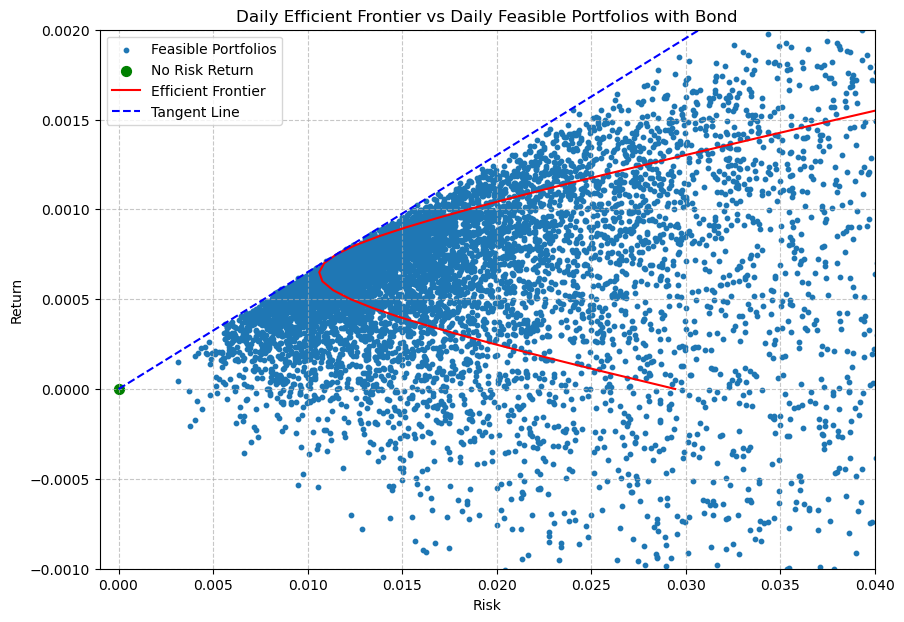

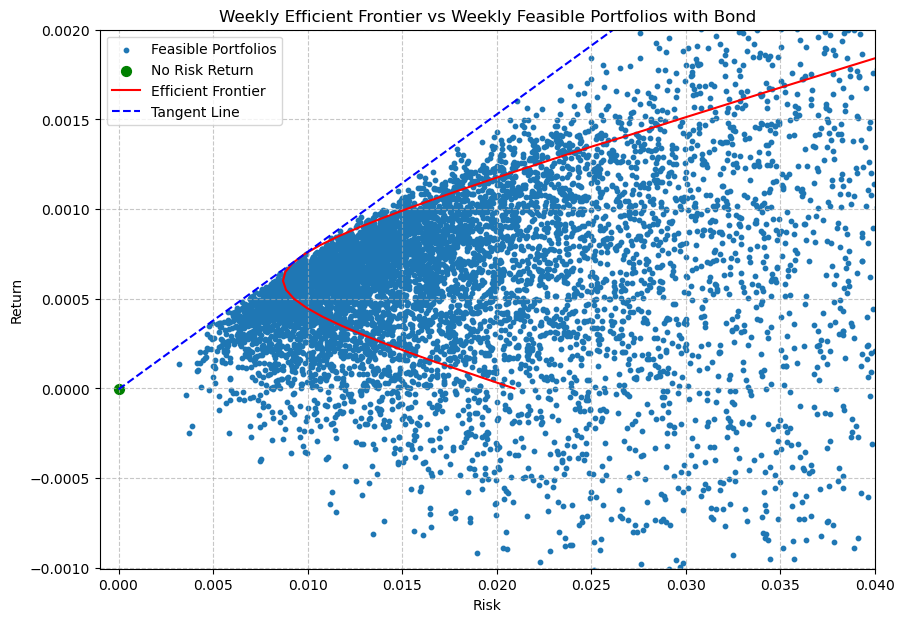

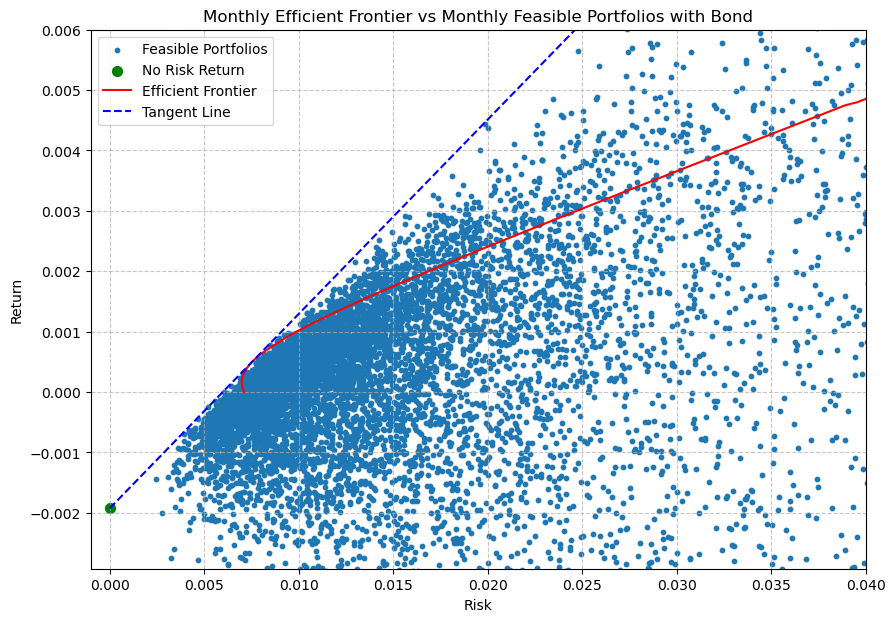

In [30]:
plot_efficient_frontier_vs_feasible(daily_efficient_frontier,
                                    wallets_with_bond["Daily_Risk"],
                                    wallets_with_bond["Daily_Return"], 
                                    no_risk_ret_mean_daily,
                                    pd_tang_daily,
                                    "Daily Efficient Frontier vs Daily Feasible Portfolios with Bond", 
                                    x_lim = 0.04, 
                                    y_lim = 0.002)

plot_efficient_frontier_vs_feasible(weekly_efficient_frontier,
                                    wallets_with_bond["Weekly_Risk"],
                                    wallets_with_bond["Weekly_Return"], 
                                    no_risk_ret_mean_weekly,
                                    pd_tang_weekly,
                                    "Weekly Efficient Frontier vs Weekly Feasible Portfolios with Bond", 
                                    x_lim = 0.04, 
                                    y_lim = 0.002)

plot_efficient_frontier_vs_feasible(monthly_efficient_frontier,
                                    wallets_with_bond["Monthly_Risk"],
                                    wallets_with_bond["Monthly_Return"], 
                                    no_risk_ret_mean_monthly,
                                    pd_tang_monthly,
                                    "Monthly Efficient Frontier vs Monthly Feasible Portfolios with Bond", 
                                    x_lim = 0.04, 
                                    y_lim = 0.006)

In [31]:
sigma = daily_cov
r_m = log_daily_ret_rates.mean()  # Vettore dei rendimenti medi
print(r_m)
r_0 = no_risk_ret_mean_daily * 5  # Rendimento privo di rischio

# Costruzione del sistema lineare
A = sigma  # Matrice delle covarianze
b = r_m - r_0  # Vettore del lato destro

# Risoluzione del sistema lineare
v_star = np.linalg.solve(A, b)

# Calcolo di V* e dei pesi del portafoglio
V_star = np.sum(v_star)  # Somma degli elementi di v_star
w_T = v_star / V_star  # Pesi normalizzati del portafoglio

# Output
print("Soluzione del sistema lineare (v*):", v_star)
print("V*:", V_star)
print("Pesi del portafoglio (w^T):", w_T)


AAPL    0.000914
MSFT    0.000851
AMZN    0.000907
JPM     0.000645
WMT     0.000537
dtype: float64
Soluzione del sistema lineare (v*): [1.38560194 1.11288174 0.65298956 0.50880737 2.09111858]
V*: 5.751399180476524
Pesi del portafoglio (w^T): [0.24091563 0.19349757 0.11353577 0.08846671 0.36358432]


### Test CAPM hypotesis


In [32]:
mcap_stocks = {}
for ticker, shares in shares_outstanding_index_date.items():
    df = shares.copy()
    df = df[~df.index.duplicated(keep=False)]
    #print(df)
    # Aggiungo le date mancanti
    df = df.resample("D").ffill()
    #unisco il dataframe con il dataframe delle azioni

    #copio il dataframe delle azioni
    df_stock = stocks[ticker].copy()
    # rendo la data l'indice
    df_stock.set_index("Date", inplace=True)
    #print(df_stock)

    #prendo solo l'adj close
    df_stock = df_stock[["Adj Close"]]

    # rendo le date compatibili andando ad unificare il formato
    df_stock.index = df_stock.index.astype(str)
    df_stock.index = pd.to_datetime(df_stock.index)
    df_stock.index = df_stock.index.tz_localize(None)
    df.index = df.index.astype(str)
    df.index = pd.to_datetime(df.index, utc=True)
    df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()

    #unisco i due dataframe
    df2 = df.join(df_stock, how="inner")

    #calcolo la capitalizzazione di mercato
    df2["MarketCap"] = df2["Shares"] * df2["Adj Close"]
    if ticker == "AMZN":
        print(df2)
    mcap_stocks[ticker] = df2



# Unisco i dati in un unico dataframe
all_mcap_stocks = pd.DataFrame()
for ticker, stock in mcap_stocks.items():
    df = pd.DataFrame()
    df = stock.copy()
    df = df.rename(columns={"MarketCap": ticker})
    all_mcap_stocks = pd.concat([all_mcap_stocks, df[ticker]], axis=1)

#print(all_mcap_stocks)
#tolgo le righe con valori mancanti
all_mcap_stocks.dropna(inplace=True)
print(all_mcap_stocks)

    

                 Shares   Adj Close     MarketCap
2015-10-23    468762000   29.951500  1.404013e+10
2015-10-26    468762000   30.430500  1.426466e+10
2015-10-27    468762000   30.550501  1.432091e+10
2015-10-28    468762000   30.855000  1.446365e+10
2015-10-29    468762000   31.327499  1.468514e+10
...                 ...         ...           ...
2024-11-19  10562499584  204.610001  2.161193e+12
2024-11-20  10515000320  202.880005  2.133283e+12
2024-11-21  10515000320  198.380005  2.085966e+12
2024-11-22  10515000320  197.119995  2.072717e+12
2024-11-25  10515000320  201.449997  2.118247e+12

[2288 rows x 3 columns]
                             AAPL          MSFT          AMZN           JPM  \
2015-12-02 00:00:00  1.468325e+11  3.890037e+11  1.584439e+10  1.911694e+11   
2015-12-03 00:00:00  1.454687e+11  3.818875e+11  1.561563e+10  1.887031e+11   
2015-12-04 00:00:00  1.503050e+11  3.939359e+11  1.576540e+10  1.946968e+11   
2015-12-07 00:00:00  1.493579e+11  3.932313e+11  1.569954e+

In [35]:
def plot_market_line_vs_capm_wallets(data, 
                                        no_risk_ret, 
                                        capm_risk,
                                        capm_ret,
                                        straight_line_capm,
                                        eq_risk,
                                        eq_ret,
                                        straight_line_eq,
                                        tang_risk,
                                        tang_ret,
                                        pd_tang,
                                        title, 
                                        x_lim = None, 
                                        y_lim = None):
    plt.figure(figsize=(10, 7))
    plt.scatter(0, no_risk_ret, alpha=1, label="No Risk Return", s=50, color="green")
    plt.scatter(capm_risk, capm_ret, alpha=1, label="CAPM wallet", s=50, color="orange")
    plt.scatter(eq_risk, eq_ret, alpha=1, label="Equally weighted wallet", s=50, color="purple")
    plt.scatter(tang_risk, tang_ret, alpha=1, label="Tangent wallet", s=50, color="blue")
    plt.plot(data["Risk"], data["Return"], alpha=1, label="Efficient Frontier", color="red")
    plt.plot(pd_tang["Risk"], pd_tang["Return"], alpha=1, label="Tangent Line", color="blue", linestyle="--")
    plt.plot(straight_line_capm["Risk"], straight_line_capm["Return"], alpha=1, label="CAPM Line", color="orange", linestyle="--")
    plt.plot(straight_line_eq["Risk"], straight_line_eq["Return"], alpha=1, label="Equally weighted Line", color="purple", linestyle="--")
    plt.title(title)
    plt.xlabel("Risk")
    plt.ylabel("Return")
    if x_lim is not None: plt.xlim(-0.001, x_lim)
    if y_lim is not None: plt.ylim(no_risk_ret - 0.001, y_lim)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.savefig(f"docs/images/{title}.png")
    plt.show()

AAPL    0.354695
MSFT    0.395658
AMZN    0.118178
JPM     0.093358
WMT     0.038112
dtype: float64
[0.2 0.2 0.2 0.2 0.2]


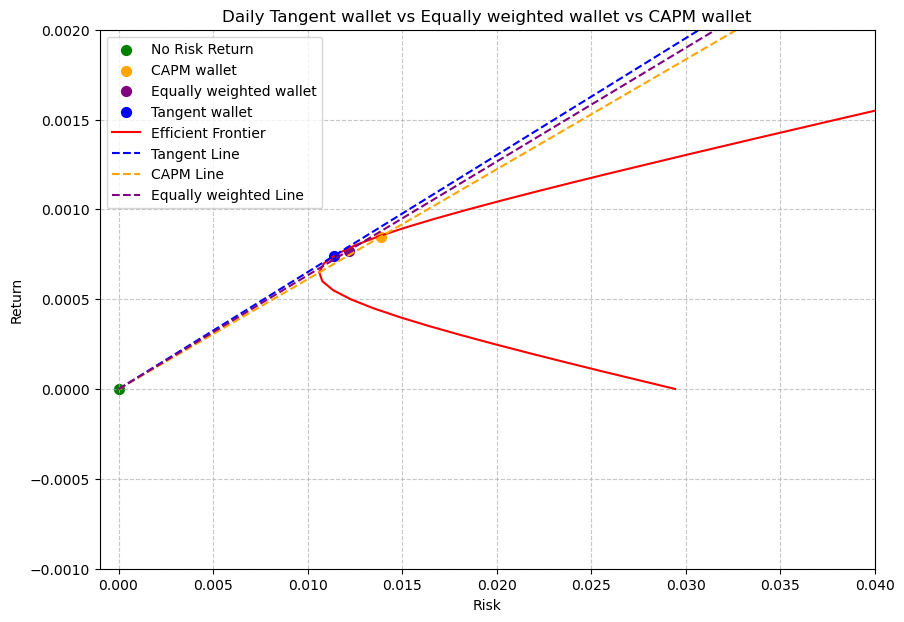

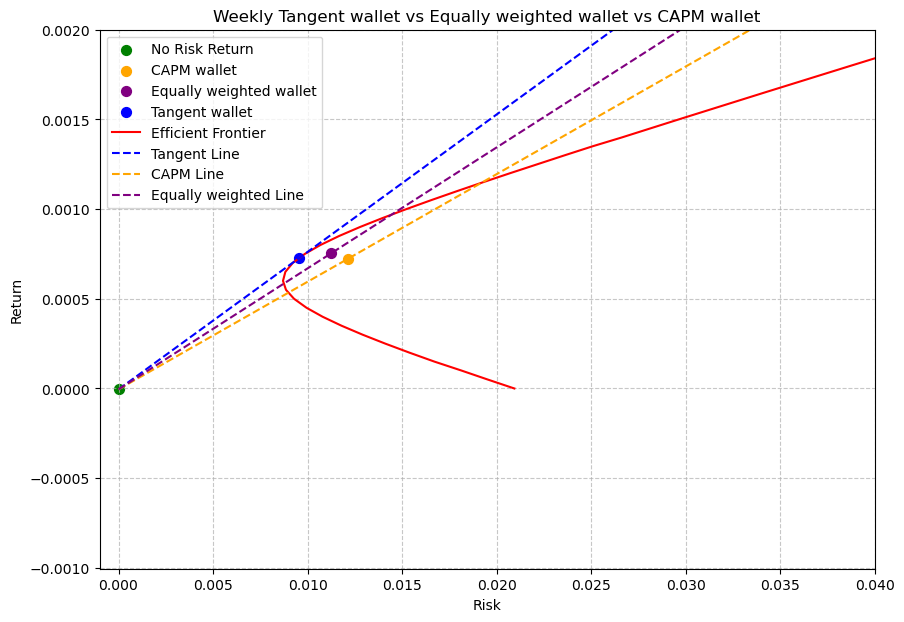

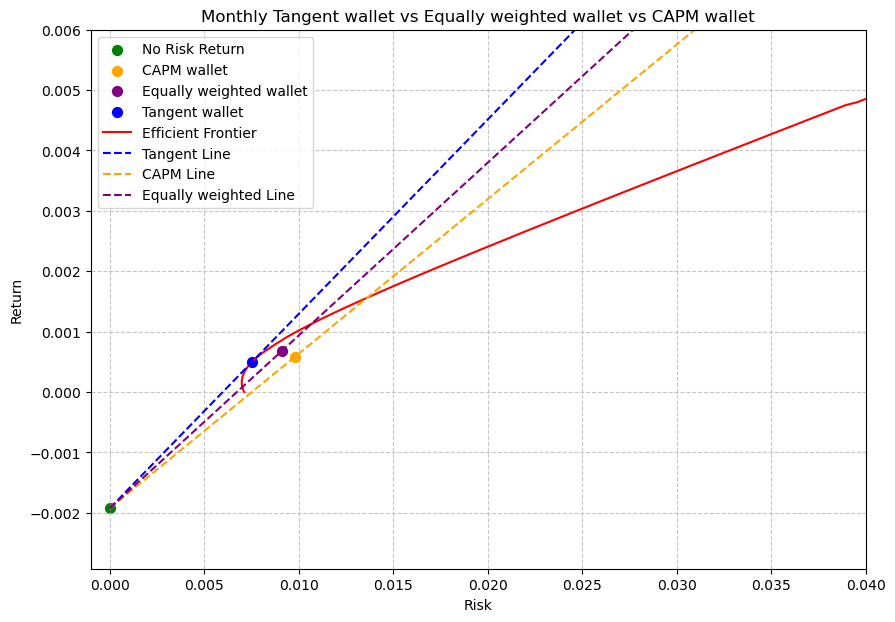

In [36]:
# Peso il portafoglio con la capitalizzazione di mercato
wallets_mcap = pd.DataFrame()

# calcolo il set di pesi utilizzando la capitalizzazione di mercato media nel periodo di riferimento
weight_cap= all_mcap_stocks.mean() / all_mcap_stocks.mean().sum()
# provo i pesi uguali
weight_eq = np.array([1/len(tickers)]*len(tickers))

print(weight_cap)
print(weight_eq)           
    
capm_ret_daily = (weight_cap * stock_exp_daily_return["Return"]).sum()
capm_risk_daily = np.sqrt(np.dot(weight_cap, np.dot(daily_cov, weight_cap)))
eq_ret_daily = (weight_eq * stock_exp_daily_return["Return"]).sum()
eq_risk_daily = np.sqrt(np.dot(weight_eq, np.dot(daily_cov, weight_eq)))
tang_ret_daily = (tangent_weights_daily * stock_exp_daily_return["Return"]).sum()
tang_risk_daily = np.sqrt(np.dot(tangent_weights_daily, np.dot(daily_cov, tangent_weights_daily)))

def straight_line_2_points(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    q = y1 - m * x1
    return m, q

# genero la retta combinazione lineare tra il rendimento senza rischio e il rendimento del portafoglio con la capitalizzazione di mercato
straight_line_capm_daily = []
for x in np.arange(0, 0.5, 0.0001):
    m, q = straight_line_2_points(0, 
                                     no_risk_ret_mean_daily, 
                                     capm_risk_daily, 
                                     capm_ret_daily)
    y = m * x + q
    straight_line_capm_daily.append([x, y])

straight_line_capm_daily = pd.DataFrame(straight_line_capm_daily, columns=["Risk", "Return"])

straight_line_eq_daily = []
for x in np.arange(0, 0.5, 0.0001):
    m, q = straight_line_2_points(0, 
                                     no_risk_ret_mean_daily, 
                                     eq_risk_daily, 
                                     eq_ret_daily)
    y = m * x + q
    straight_line_eq_daily.append([x, y])

straight_line_eq_daily = pd.DataFrame(straight_line_eq_daily, columns=["Risk", "Return"])

capm_ret_weekly = (weight_cap * stock_exp_weekly_return["Return"]).sum()
capm_risk_weekly = np.sqrt(np.dot(weight_cap, np.dot(weekly_cov, weight_cap)))
eq_ret_weekly = (weight_eq * stock_exp_weekly_return["Return"]).sum()
eq_risk_weekly = np.sqrt(np.dot(weight_eq, np.dot(weekly_cov, weight_eq)))
tang_ret_weekly = (tangent_weights_weekly * stock_exp_weekly_return["Return"]).sum()
tang_risk_weekly = np.sqrt(np.dot(tangent_weights_weekly, np.dot(weekly_cov, tangent_weights_weekly)))

straight_line_capm_weekly = []
for x in np.arange(0, 0.5, 0.0001):
    m, q = straight_line_2_points(0, 
                                     no_risk_ret_mean_weekly,
                                        capm_risk_weekly,
                                        capm_ret_weekly)
    y = m * x + q
    straight_line_capm_weekly.append([x, y])

straight_line_capm_weekly = pd.DataFrame(straight_line_capm_weekly, columns=["Risk", "Return"])

straight_line_eq_weekly = []
for x in np.arange(0, 0.5, 0.0001):
    m, q = straight_line_2_points(0, 
                                     no_risk_ret_mean_weekly,
                                        eq_risk_weekly,
                                        eq_ret_weekly)
    y = m * x + q
    straight_line_eq_weekly.append([x, y])

straight_line_eq_weekly = pd.DataFrame(straight_line_eq_weekly, columns=["Risk", "Return"])

capm_ret_monthly = (weight_cap * stock_exp_monthly_return["Return"]).sum()
capm_risk_monthly = np.sqrt(np.dot(weight_cap, np.dot(monthly_cov, weight_cap)))
eq_ret_monthly = (weight_eq * stock_exp_monthly_return["Return"]).sum()
eq_risk_monthly = np.sqrt(np.dot(weight_eq, np.dot(monthly_cov, weight_eq)))
tang_ret_monthly = (tangent_weights_monthly * stock_exp_monthly_return["Return"]).sum()
tang_risk_monthly = np.sqrt(np.dot(tangent_weights_monthly, np.dot(monthly_cov, tangent_weights_monthly)))

straight_line_capm_monthly = []
for x in np.arange(0, 0.5, 0.0001):
    m, q = straight_line_2_points(0, 
                                     no_risk_ret_mean_monthly,
                                        capm_risk_monthly,
                                        capm_ret_monthly)
    y = m * x + q
    straight_line_capm_monthly.append([x, y])

straight_line_capm_monthly = pd.DataFrame(straight_line_capm_monthly, columns=["Risk", "Return"])

straight_line_eq_monthly = []
for x in np.arange(0, 0.5, 0.0001):
    m, q = straight_line_2_points(0, 
                                     no_risk_ret_mean_monthly,
                                        eq_risk_monthly,
                                        eq_ret_monthly)
    y = m * x + q
    straight_line_eq_monthly.append([x, y])

straight_line_eq_monthly = pd.DataFrame(straight_line_eq_monthly, columns=["Risk", "Return"])


plot_market_line_vs_capm_wallets(daily_efficient_frontier,
                                    no_risk_ret_mean_daily,
                                    capm_risk_daily,
                                    capm_ret_daily,
                                    straight_line_capm_daily,
                                    eq_risk_daily,
                                    eq_ret_daily,
                                    straight_line_eq_daily,
                                    tang_risk_daily,
                                    tang_ret_daily,
                                    pd_tang_daily,
                                    "Daily Tangent wallet vs Equally weighted wallet vs CAPM wallet", 
                                    x_lim = 0.04, 
                                    y_lim = 0.002)

plot_market_line_vs_capm_wallets(weekly_efficient_frontier,
                                    no_risk_ret_mean_weekly,
                                    capm_risk_weekly,
                                    capm_ret_weekly,
                                    straight_line_capm_weekly,
                                    eq_risk_weekly,
                                    eq_ret_weekly,
                                    straight_line_eq_weekly,
                                    tang_risk_weekly,
                                    tang_ret_weekly,
                                    pd_tang_weekly,
                                    "Weekly Tangent wallet vs Equally weighted wallet vs CAPM wallet", 
                                    x_lim = 0.04, 
                                    y_lim = 0.002)

plot_market_line_vs_capm_wallets(monthly_efficient_frontier,
                                    no_risk_ret_mean_monthly,
                                    capm_risk_monthly,
                                    capm_ret_monthly,
                                    straight_line_capm_monthly,
                                    eq_risk_monthly,
                                    eq_ret_monthly,
                                    straight_line_eq_monthly,
                                    tang_risk_monthly,
                                    tang_ret_monthly,
                                    pd_tang_monthly,
                                    "Monthly Tangent wallet vs Equally weighted wallet vs CAPM wallet", 
                                    x_lim = 0.04, 
                                    y_lim = 0.006)



    

### Portafogli sulla capital market line

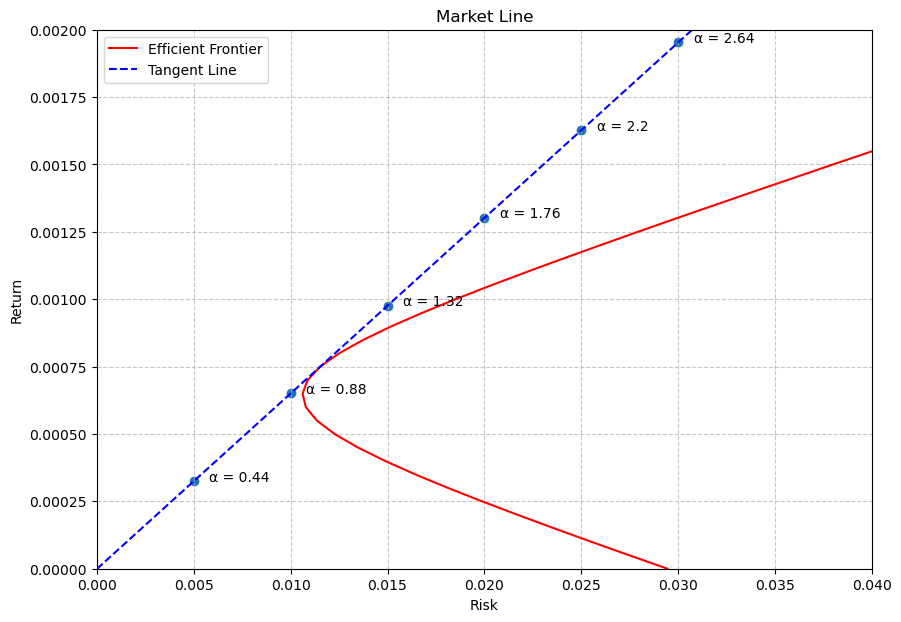

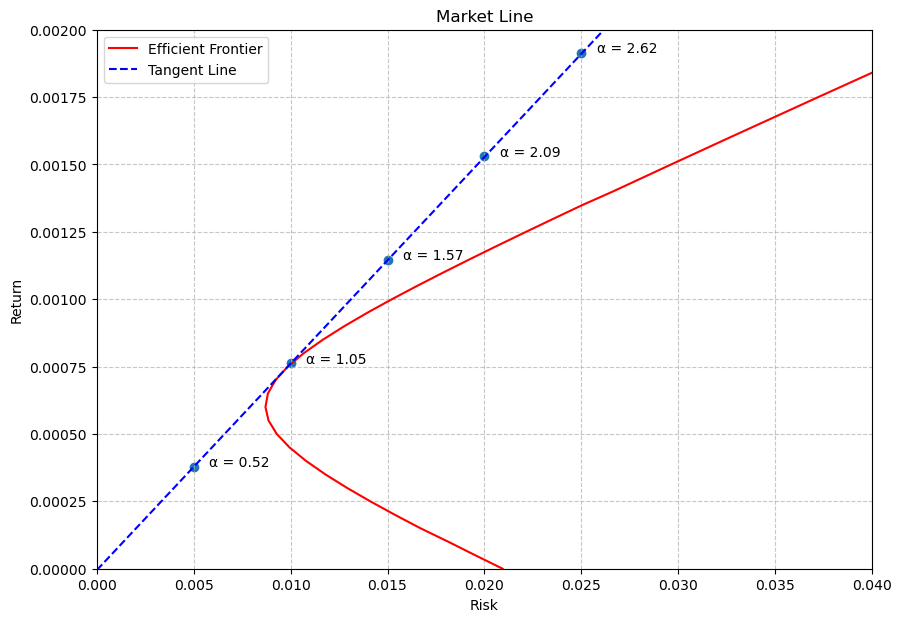

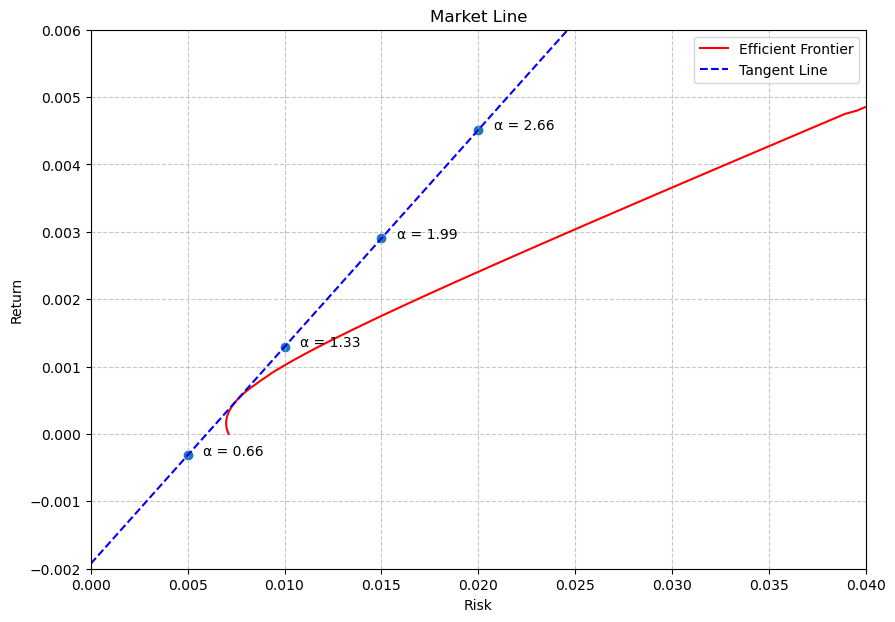

In [34]:
# Dato il rischio trovo il portafoglio di massimo rendimento
market_line_daily = []
market_line_weekly = []
market_line_monthly = []
for risk_wtd in np.arange(0.005, 0.04, 0.005):
    ret_max_daily = no_risk_ret_mean_daily + (tang_ret_daily - no_risk_ret_mean_daily) / tang_risk_daily * risk_wtd
    ret_max_weekly = no_risk_ret_mean_weekly + (tang_ret_weekly - no_risk_ret_mean_weekly) / tang_risk_weekly * risk_wtd
    ret_max_monthly = no_risk_ret_mean_monthly + (tang_ret_monthly - no_risk_ret_mean_monthly) / tang_risk_monthly * risk_wtd

    alpha_daily = risk_wtd / tang_risk_daily
    alpha_weekly = risk_wtd / tang_risk_weekly
    alpha_monthly = risk_wtd / tang_risk_monthly

    market_line_daily.append([risk_wtd, ret_max_daily, alpha_daily])
    market_line_weekly.append([risk_wtd, ret_max_weekly, alpha_weekly])
    market_line_monthly.append([risk_wtd, ret_max_monthly, alpha_monthly])


market_line_daily_df = pd.DataFrame(market_line_daily, columns=["Risk", "Return", "Alpha"])
market_line_weekly_df = pd.DataFrame(market_line_weekly, columns=["Risk", "Return", "Alpha"])
market_line_monthly_df = pd.DataFrame(market_line_monthly, columns=["Risk", "Return", "Alpha"])

def plot_market_line(title, market_line, efficient_frontier, pd_tang, x_lim = (0, 0.04), y_lim = (0, 0.002)):
    plt.figure(figsize=(10, 7))
    plt.scatter(market_line["Risk"], market_line["Return"], alpha=1)
    plt.plot(efficient_frontier["Risk"], efficient_frontier["Return"], alpha=1, label="Efficient Frontier", color="red")
    plt.plot(pd_tang["Risk"], pd_tang["Return"], alpha=1, label="Tangent Line", color="blue", linestyle="--")
    plt.title("Market Line")
    plt.xlabel("Risk")
    plt.ylabel("Return")
    plt.grid(True, linestyle='--', alpha=0.7)
    for risk, ret, alpha in zip(market_line["Risk"], market_line["Return"], market_line["Alpha"]):
        plt.annotate("α = " + str(np.round(alpha, 2)), (risk + x_lim[1]/50, ret))
    plt.legend()
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.savefig(f"docs/images/{title}.png")
    plt.show()
    
plot_market_line("Daily", market_line_daily_df, daily_efficient_frontier, pd_tang_daily)
plot_market_line("Weekly", market_line_weekly_df, weekly_efficient_frontier, pd_tang_weekly)
plot_market_line("Monthly", market_line_monthly_df, monthly_efficient_frontier, pd_tang_monthly, y_lim=(-0.002, 0.006))




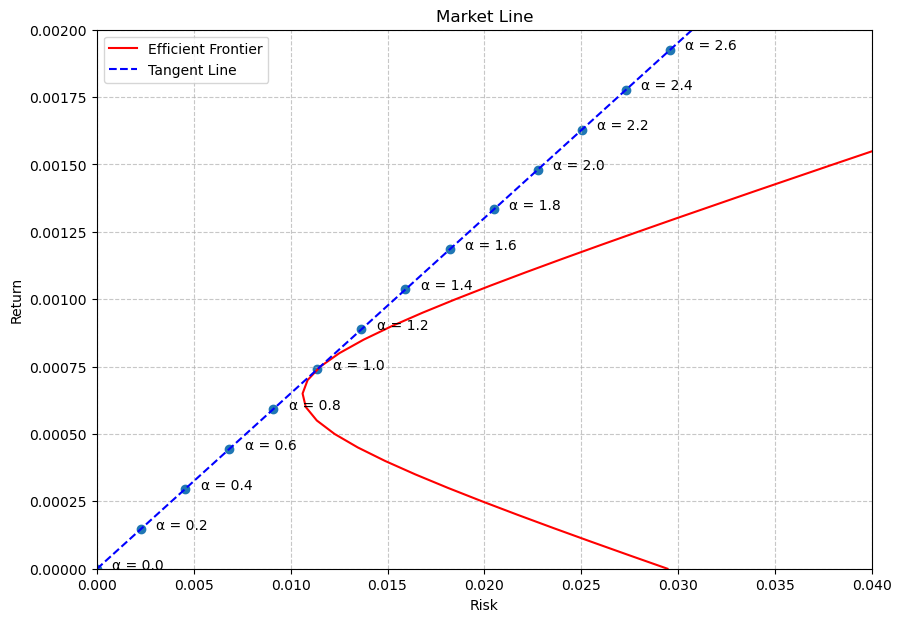

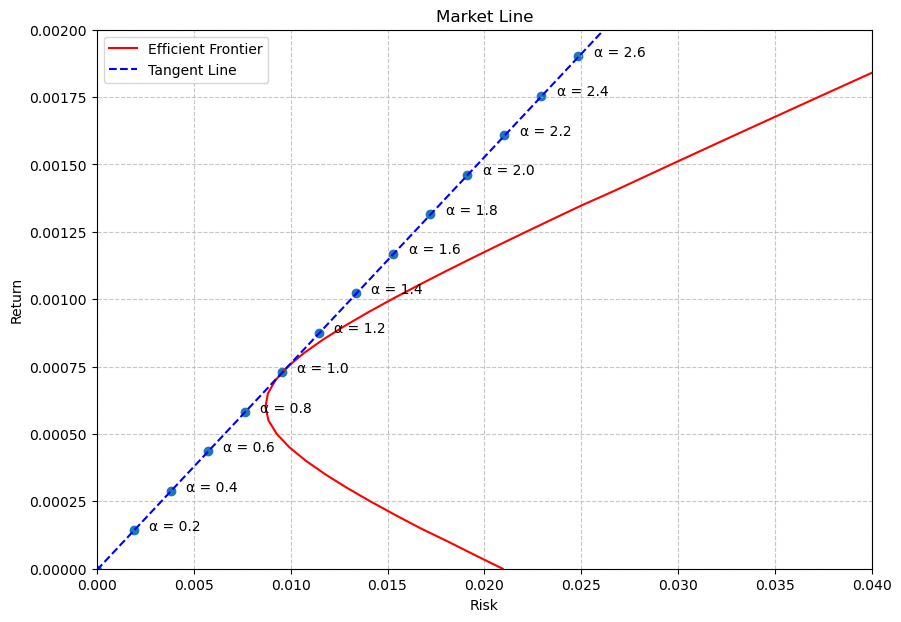

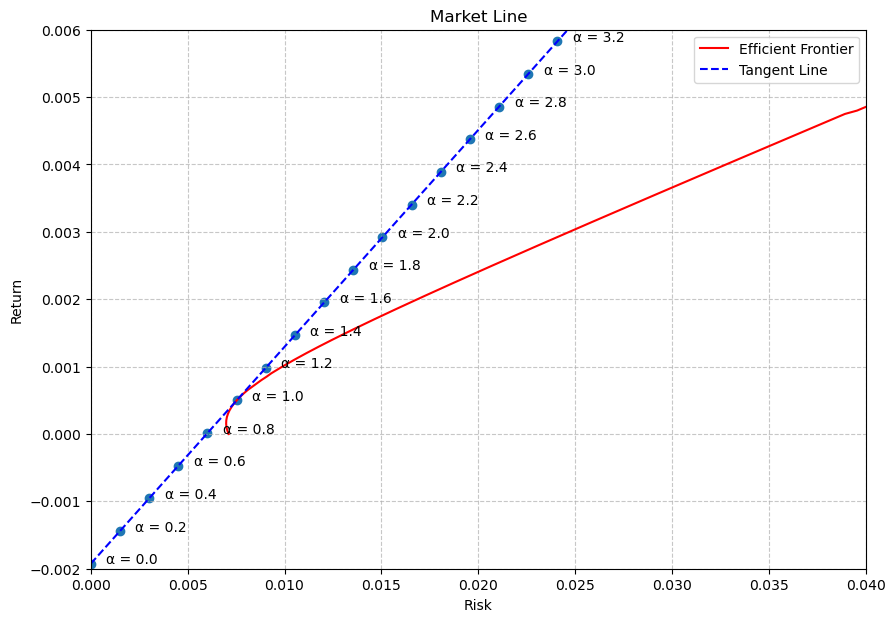

In [35]:
# Dato il rischio trovo il portafoglio di massimo rendimento
market_line_daily = []
market_line_weekly = []
market_line_monthly = []
for alpha in np.arange(0, 4, 0.2):
    risk_wtd_d = alpha * tang_risk_daily
    risk_wtd_w = alpha * tang_risk_weekly
    risk_wtd_m = alpha * tang_risk_monthly

    ret_max_d = no_risk_ret_mean_daily + (tang_ret_daily - no_risk_ret_mean_daily) / tang_risk_daily * risk_wtd_d
    ret_max_w = no_risk_ret_mean_weekly + (tang_ret_weekly - no_risk_ret_mean_weekly) / tang_risk_weekly * risk_wtd_w
    ret_max_m = no_risk_ret_mean_monthly + (tang_ret_monthly - no_risk_ret_mean_monthly) / tang_risk_monthly * risk_wtd_m

    market_line_daily.append([risk_wtd_d, ret_max_d, alpha])
    market_line_weekly.append([risk_wtd_w, ret_max_w, alpha])
    market_line_monthly.append([risk_wtd_m, ret_max_m, alpha])

market_line_daily_df = pd.DataFrame(market_line_daily, columns=["Risk", "Return", "Alpha"])
market_line_weekly_df = pd.DataFrame(market_line_weekly, columns=["Risk", "Return", "Alpha"])
market_line_monthly_df = pd.DataFrame(market_line_monthly, columns=["Risk", "Return", "Alpha"])
    
plot_market_line("Daily2", market_line_daily_df, daily_efficient_frontier, pd_tang_daily)
plot_market_line("Weekly2", market_line_weekly_df, weekly_efficient_frontier, pd_tang_weekly)
plot_market_line("Monthly2", market_line_monthly_df, monthly_efficient_frontier, pd_tang_monthly, y_lim=(-0.002, 0.006))


## Autocorrelation


### P-Autocorrelation of return rates ($RR$)

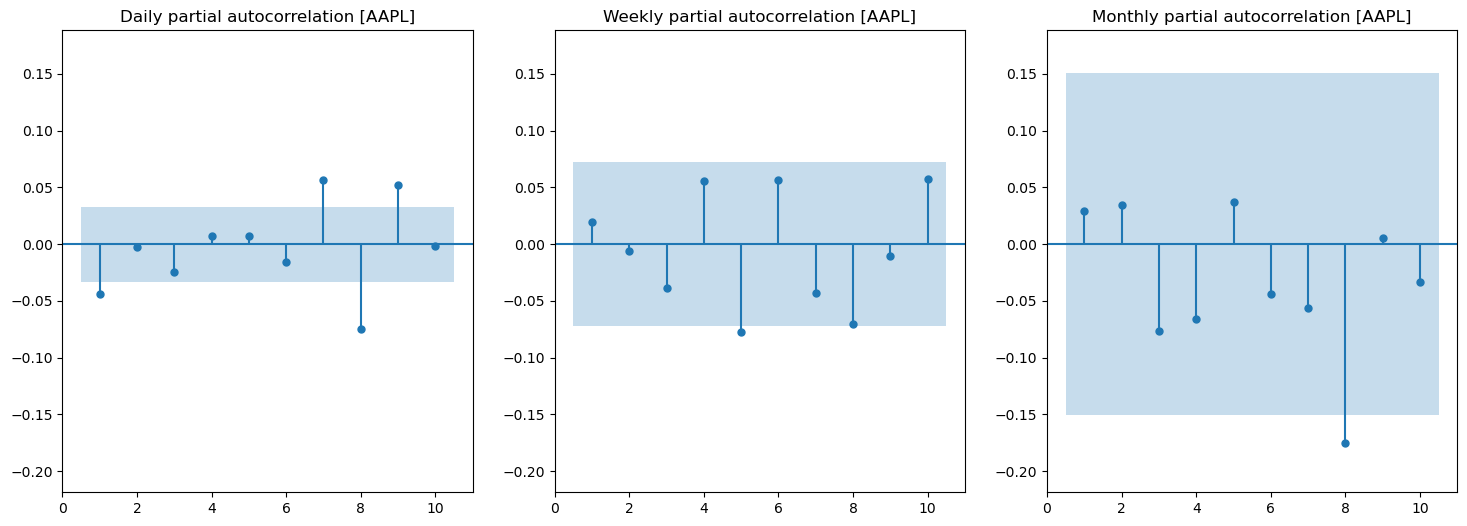

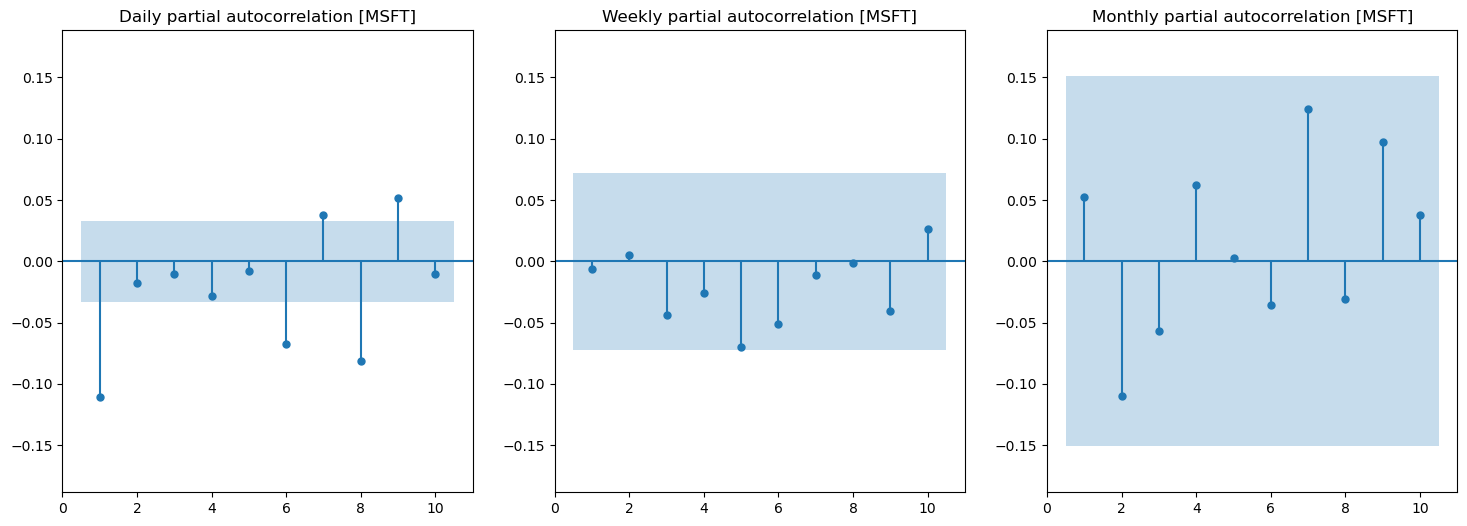

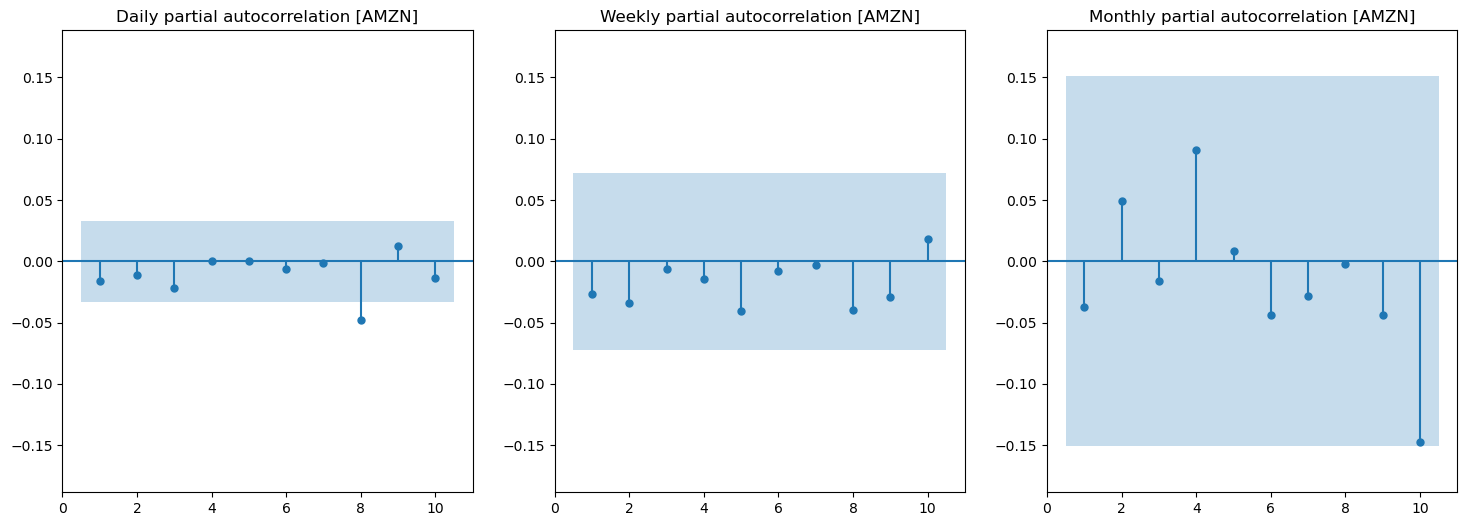

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_pacf(log_daily_ret_rates[ticker], lags=10, title="Daily partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[0])
    plot_pacf(weekly_ret_rates[ticker], lags=10, title="Weekly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[1])
    plot_pacf(monthly_ret_rates[ticker], lags=10, title="Monthly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)
    
plt.close()

# Calcolo l'autocorrelazione dei rendimentihttps://query2.finance.yahoo.com/ws/fundamentals-timeseries/v1/finance/timeseries/AMZN?symbol=AMZN&period1=1689134400&period2=1736571600 + "]", auto_ylims=True, zero=False, ax=axes[1])
plot_acf(monthly_ret_rates[ticker], lags=10, title="Monthly autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[2])
max_y = max(max(ax.get_ylim()) for ax in axes)  
min_y = min(min(ax.get_ylim()) for ax in axes)
for ax in axes:
    ax.set_ylim(min_y, max_y)

plt.close()

### P-Autocorrelation of the $|RR|$


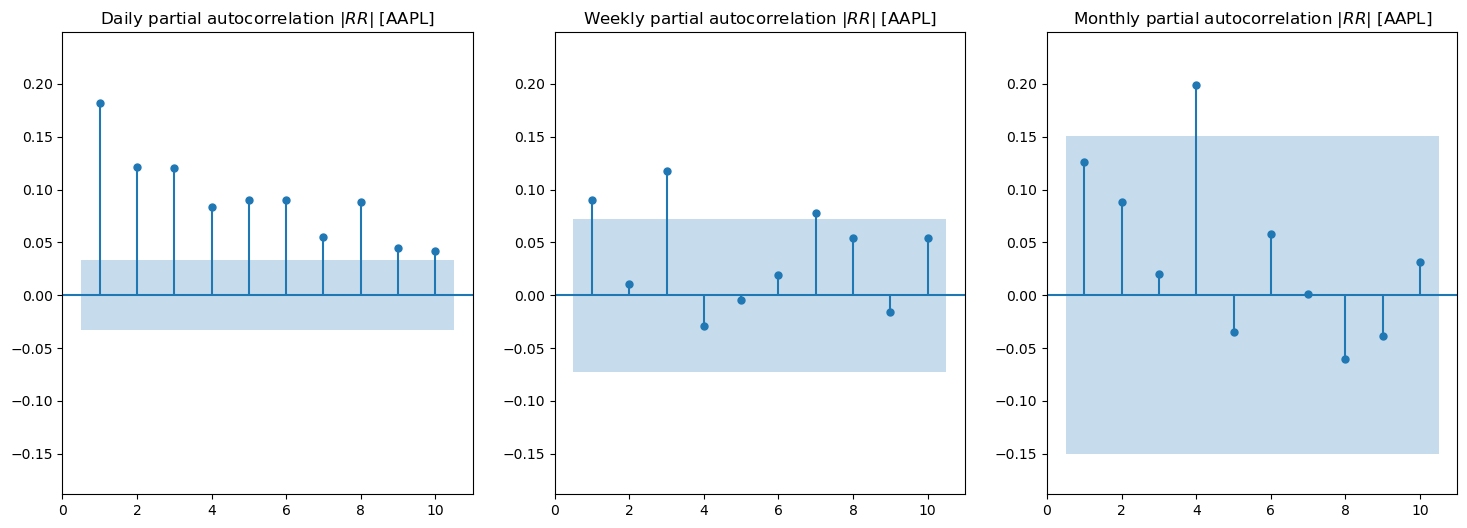

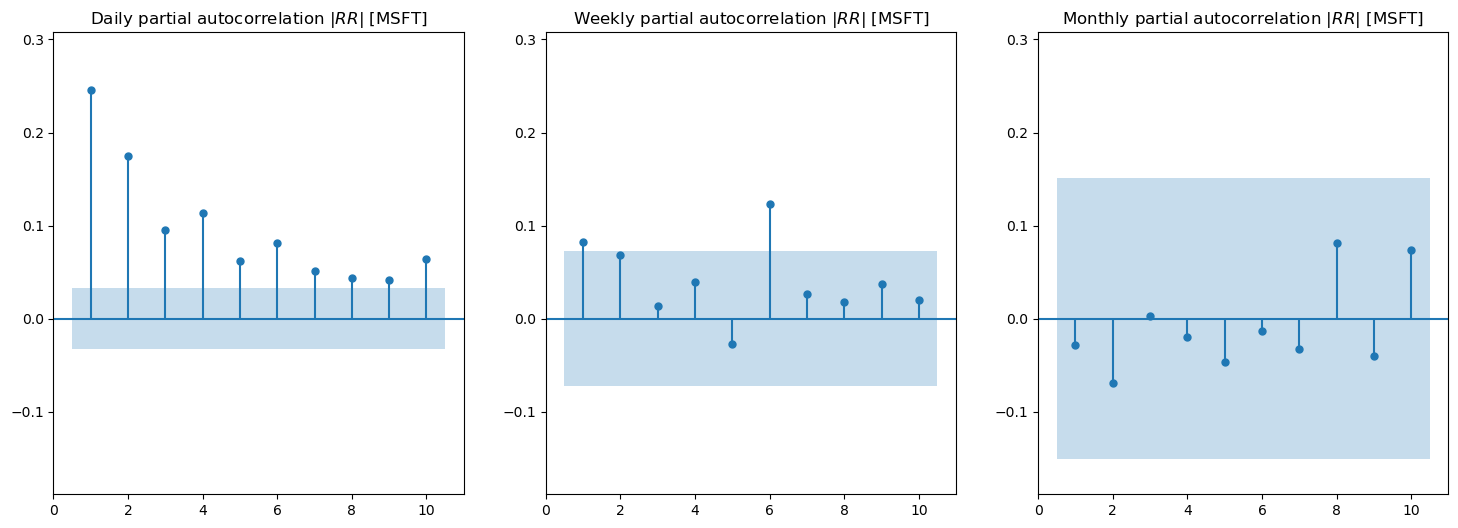

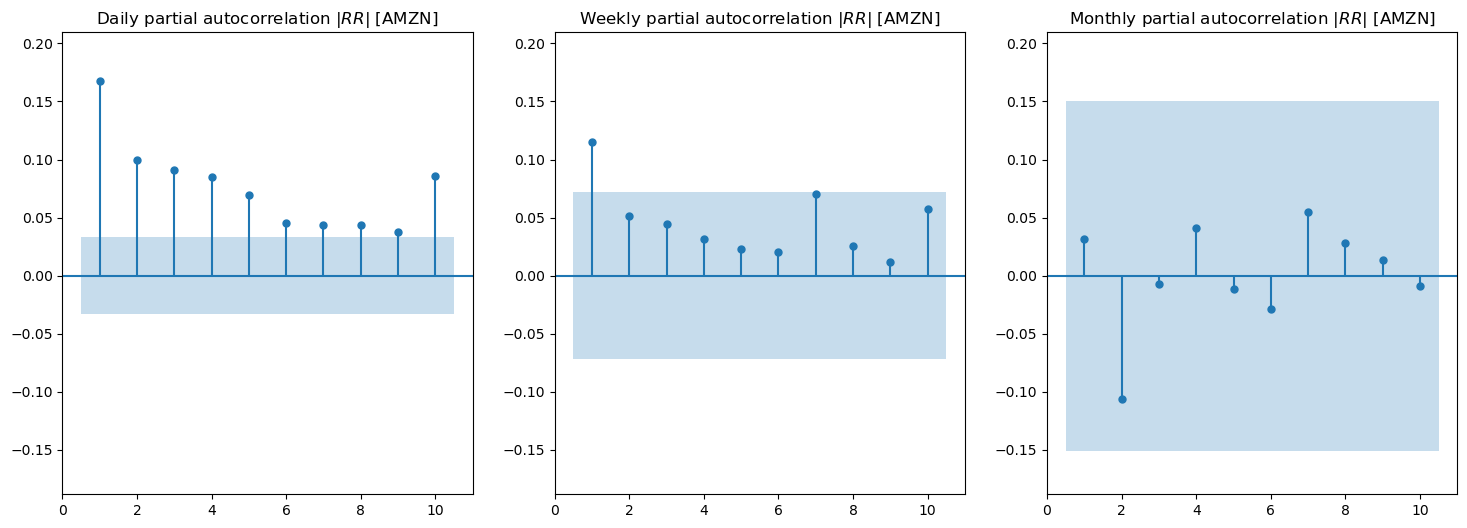

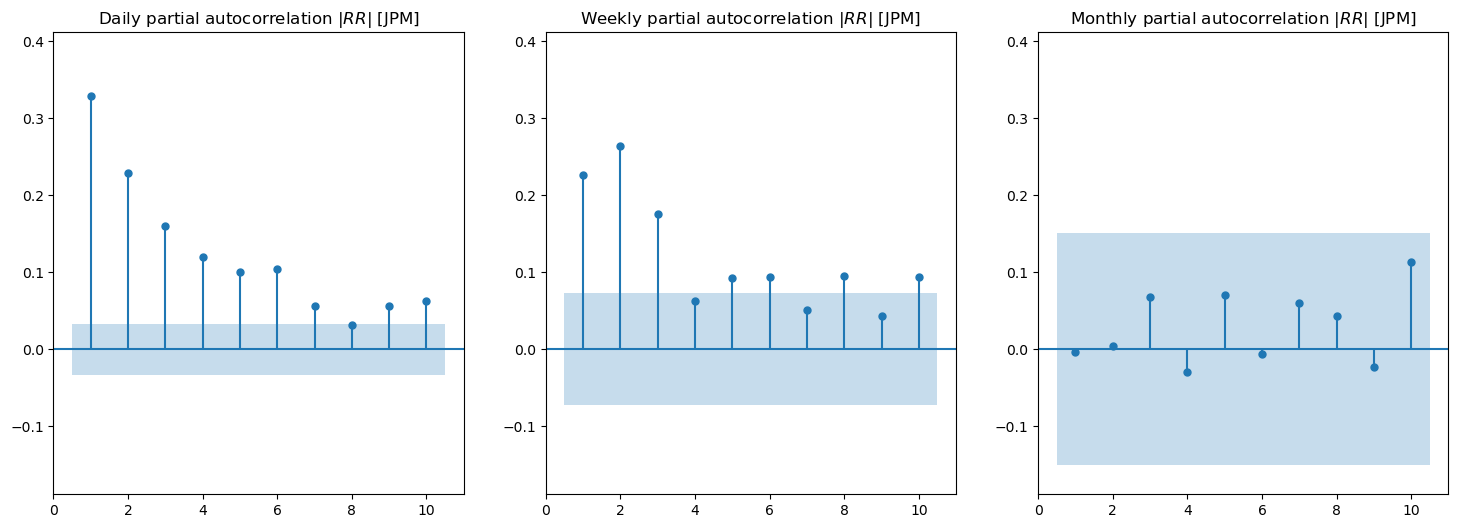

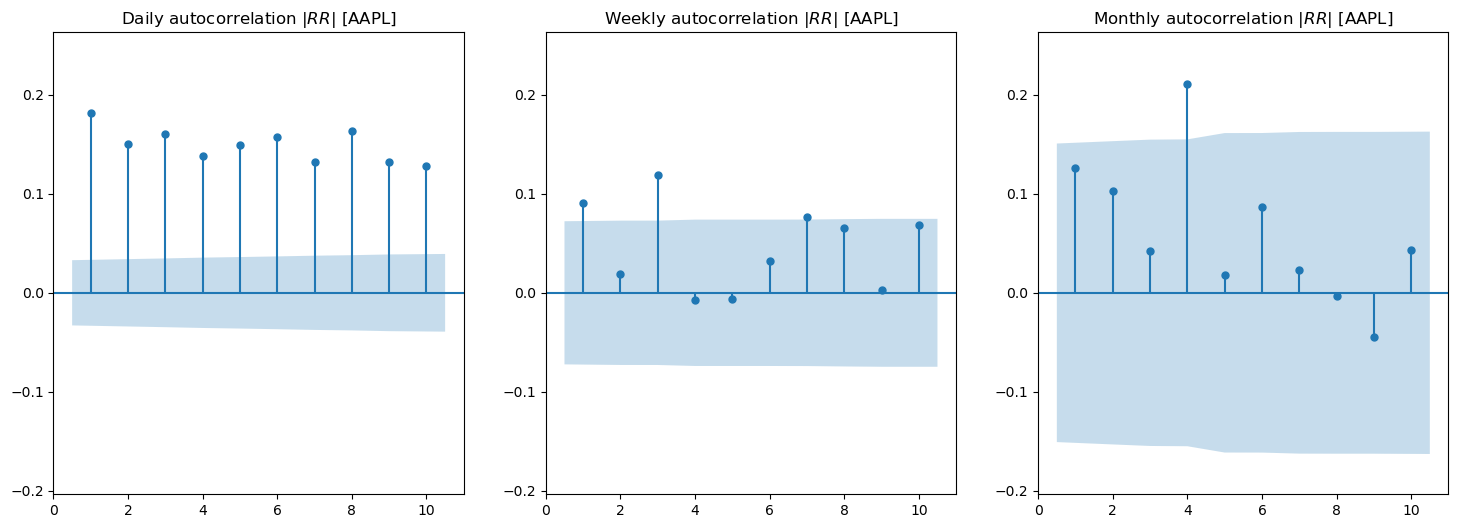

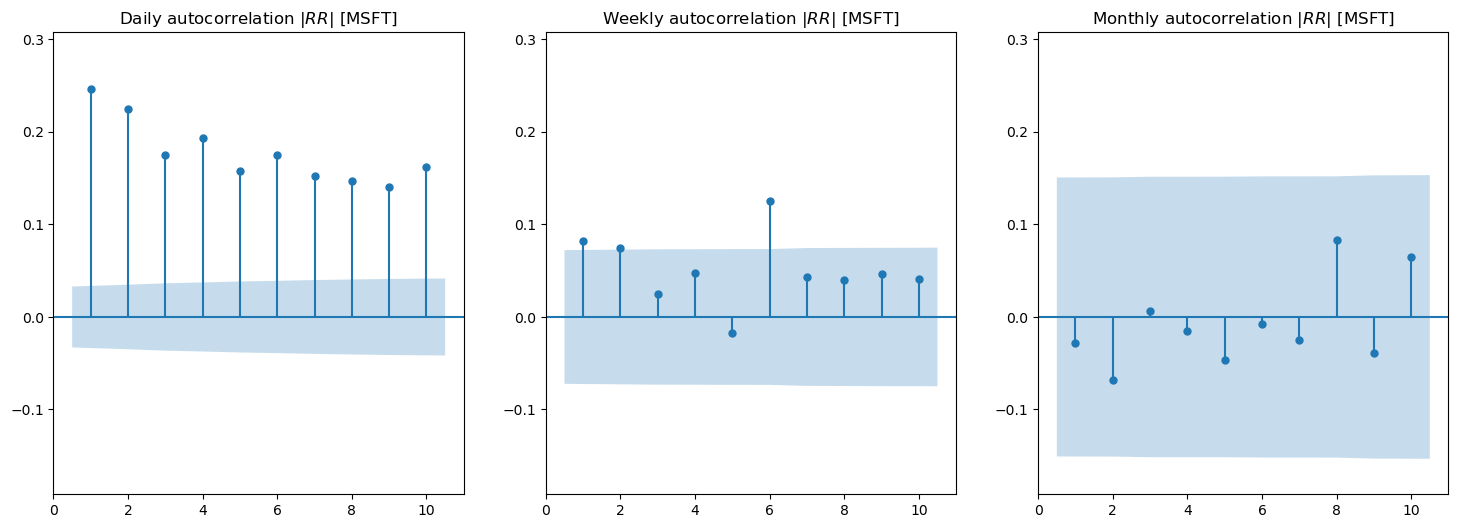

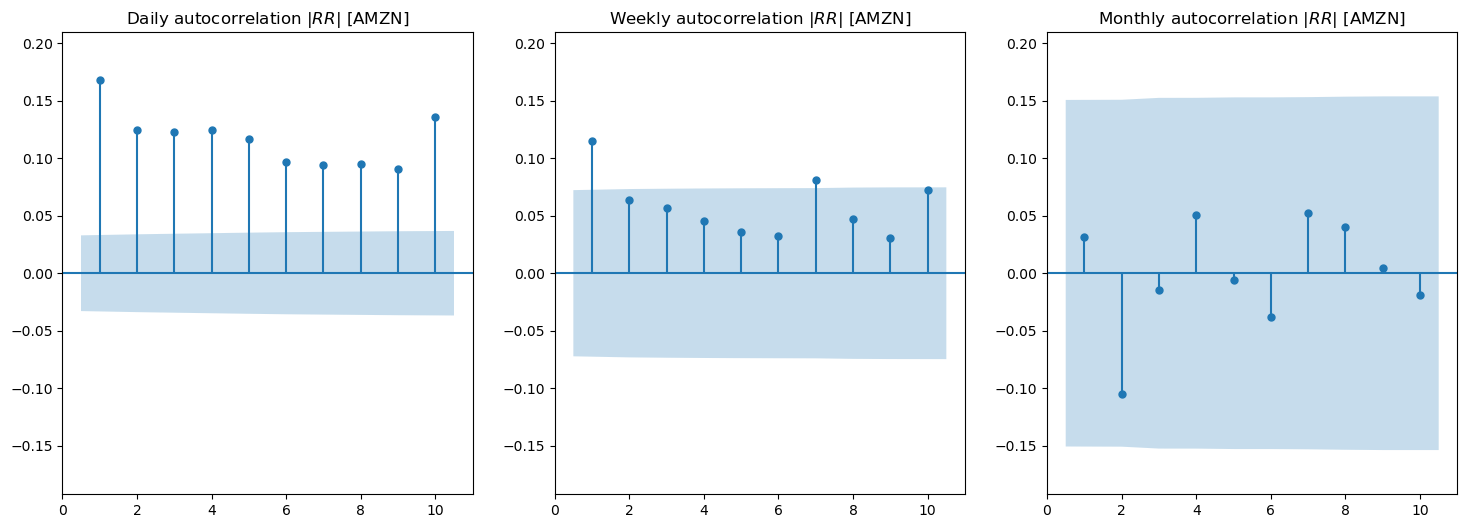

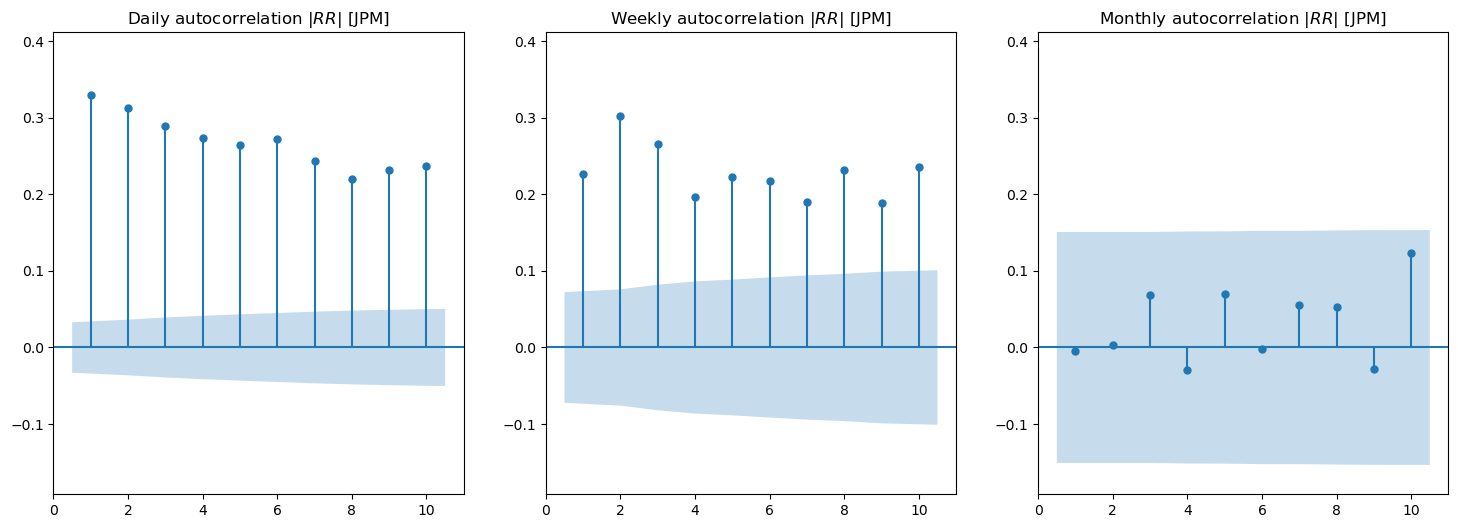

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_pacf(np.abs(log_daily_ret_rates[ticker]), lags=10, title="Daily partial autocorrelation $|RR|$ [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[0])
    plot_pacf(np.abs(weekly_ret_rates[ticker]), lags=10, title="Weekly partial autocorrelation $|RR|$ [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[1])
    plot_pacf(np.abs(monthly_ret_rates[ticker]), lags=10, title="Monthly partial autocorrelation $|RR|$ [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)
    plt.savefig(f"docs/images/partial_autocorrelation_abs_" + ticker + ".png")
plt.close()

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_acf(np.abs(log_daily_ret_rates[ticker]), lags=10, title="Daily autocorrelation $|RR|$ [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[0])
    plot_acf(np.abs(weekly_ret_rates[ticker]), lags=10, title="Weekly autocorrelation $|RR|$ [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[1])
    plot_acf(np.abs(monthly_ret_rates[ticker]), lags=10, title="Monthly autocorrelation $|RR|$ [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)
    plt.savefig(f"docs/images/autocorrelation_abs_" + ticker + ".png")
plt.close()

### P-Autocorrelation of the $RR^2$

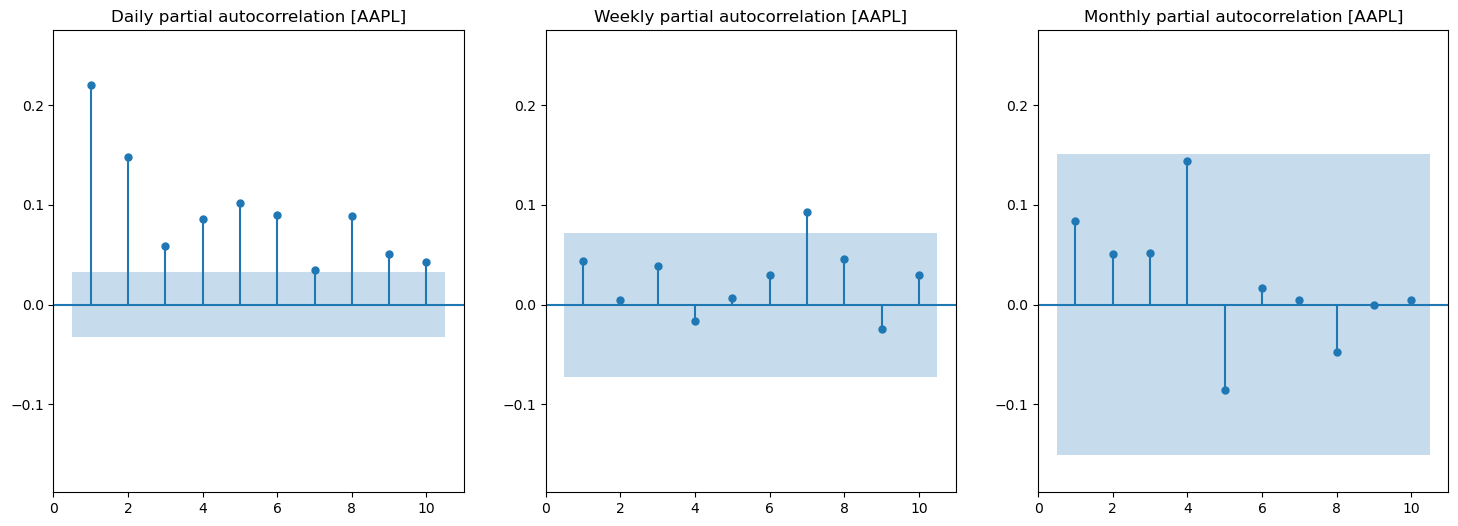

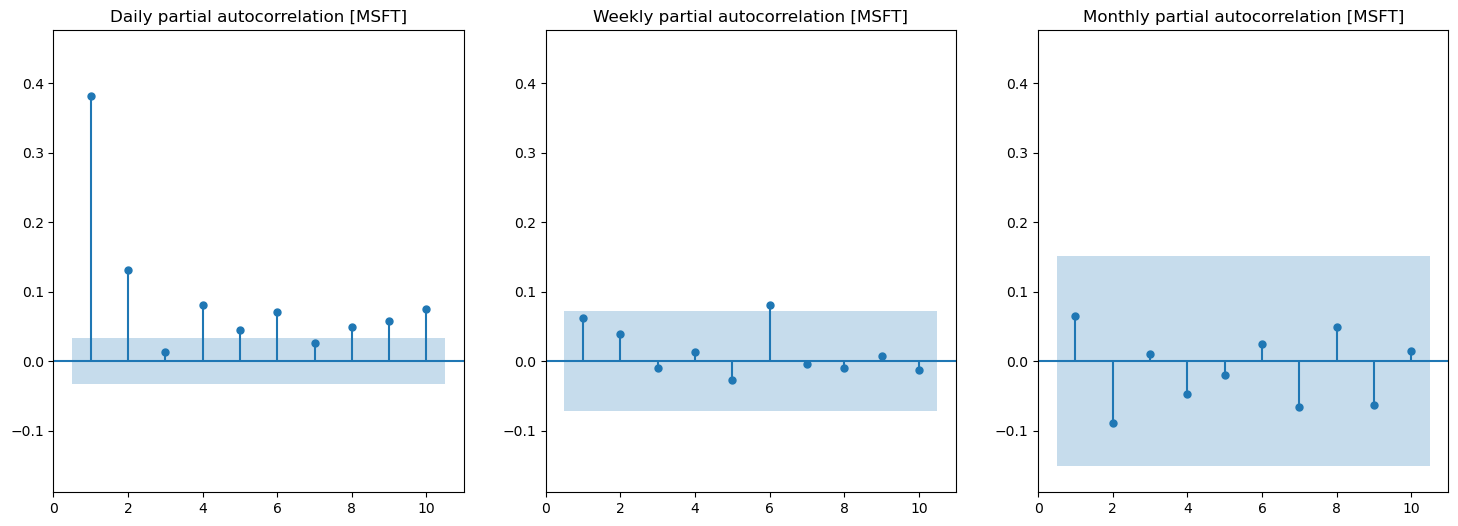

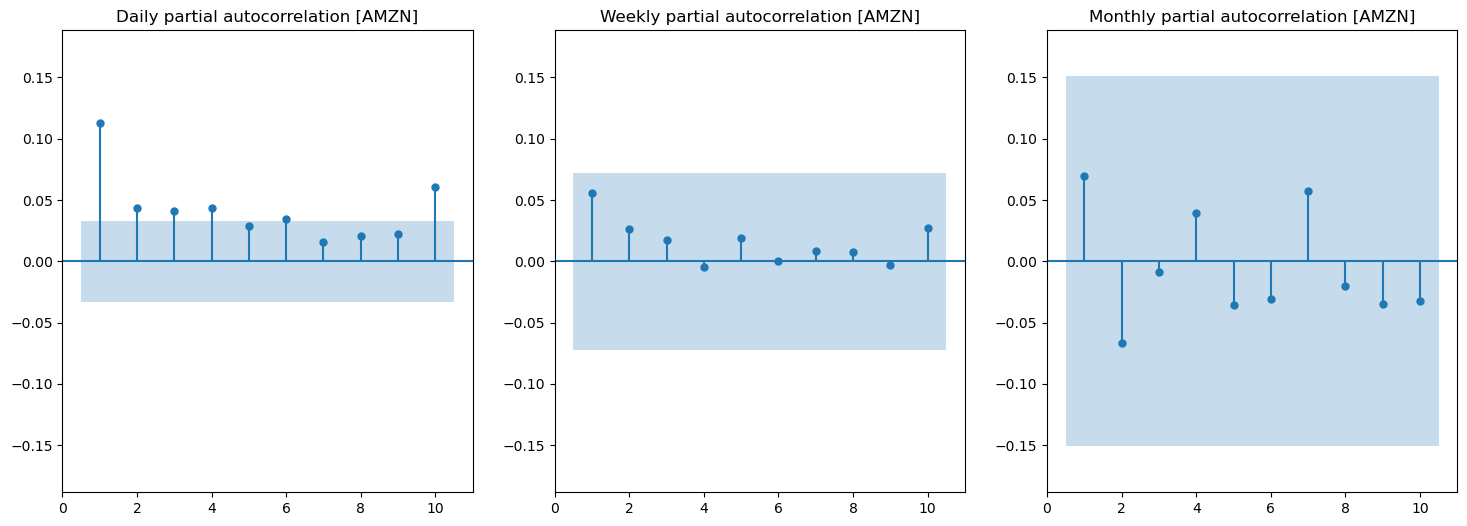

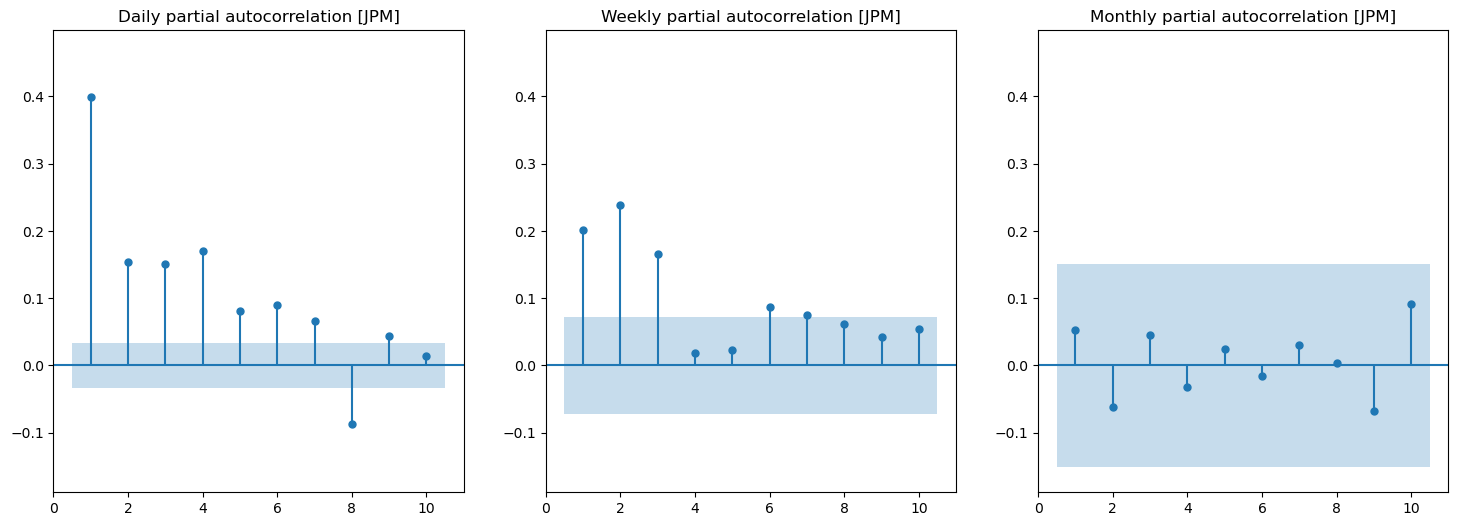

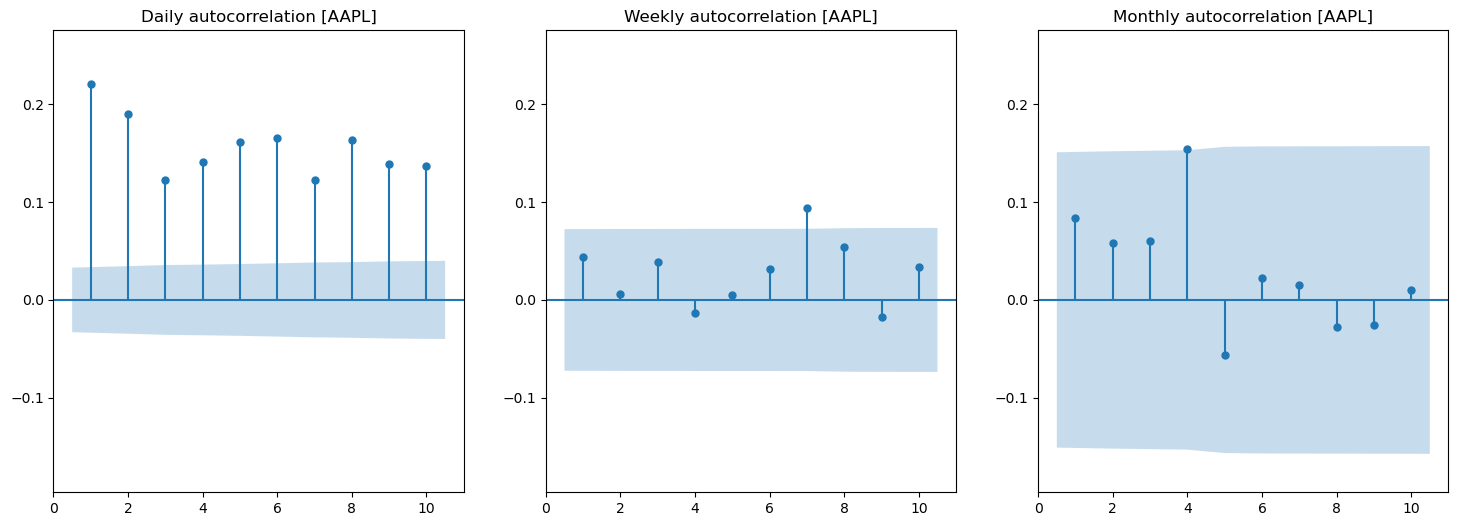

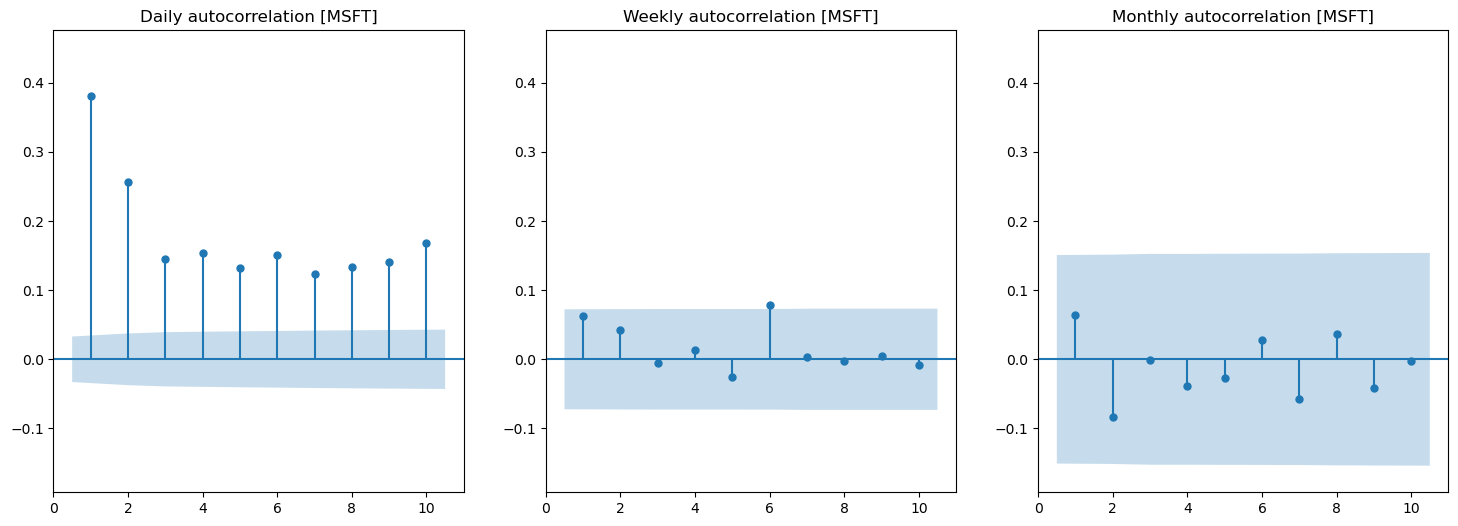

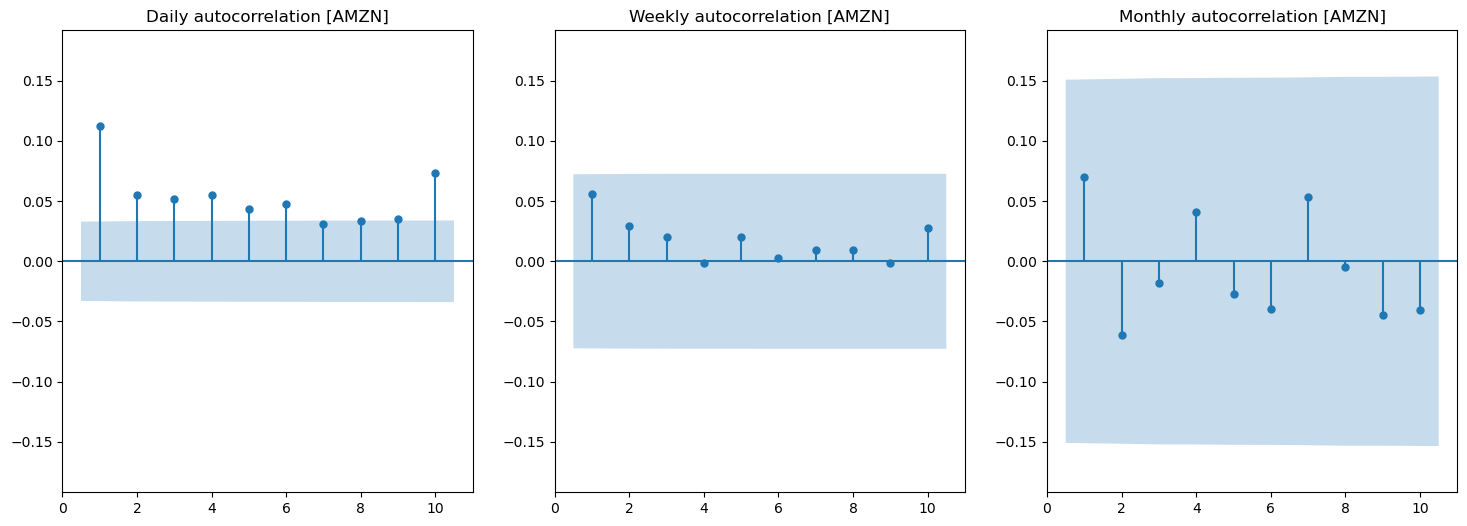

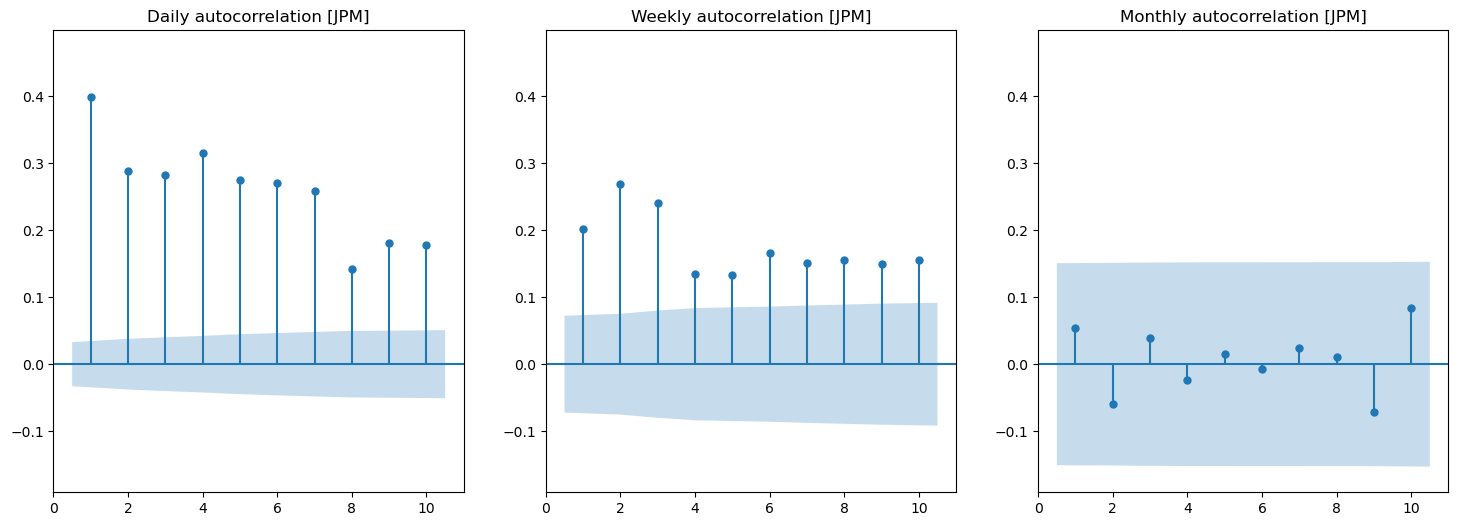

In [79]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_pacf(np.square(log_daily_ret_rates[ticker]), lags=10, title="Daily partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[0])
    plot_pacf(np.square(weekly_ret_rates[ticker]), lags=10, title="Weekly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[1])
    plot_pacf(np.square(monthly_ret_rates[ticker]), lags=10, title="Monthly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)
    
plt.close()

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_acf(np.square(log_daily_ret_rates[ticker]), lags=10, title="Daily autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[0])
    plot_acf(np.square(weekly_ret_rates[ticker]), lags=10, title="Weekly autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[1])
    plot_acf(np.square(monthly_ret_rates[ticker]), lags=10, title="Monthly autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)

plt.close()

### P-Autocorrelation of the stock values

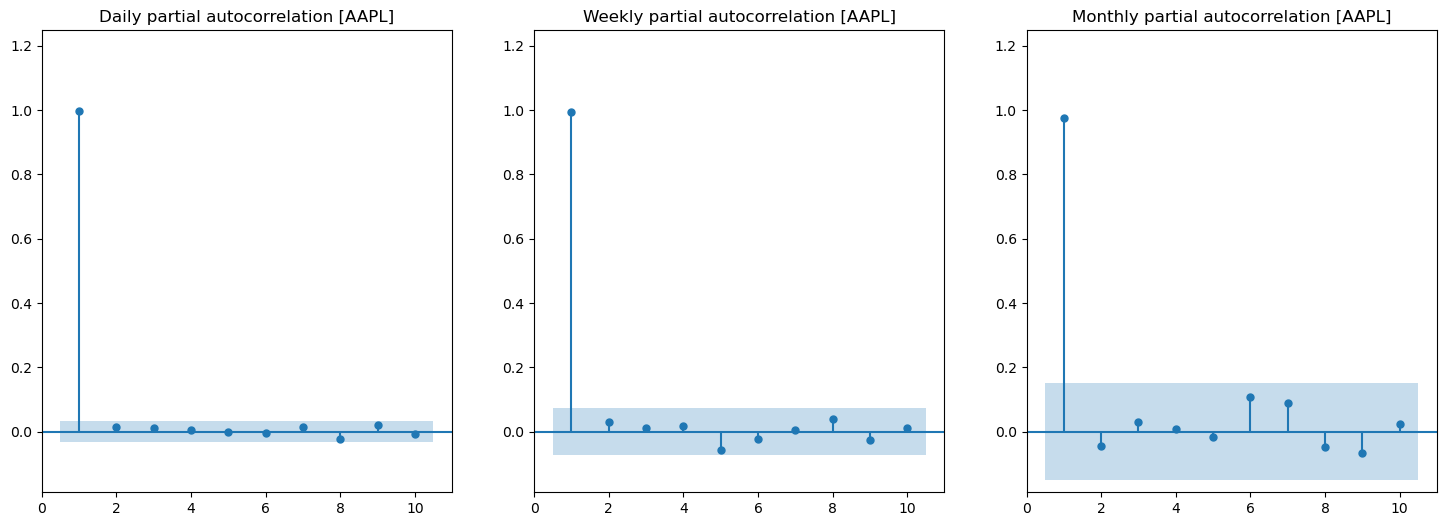

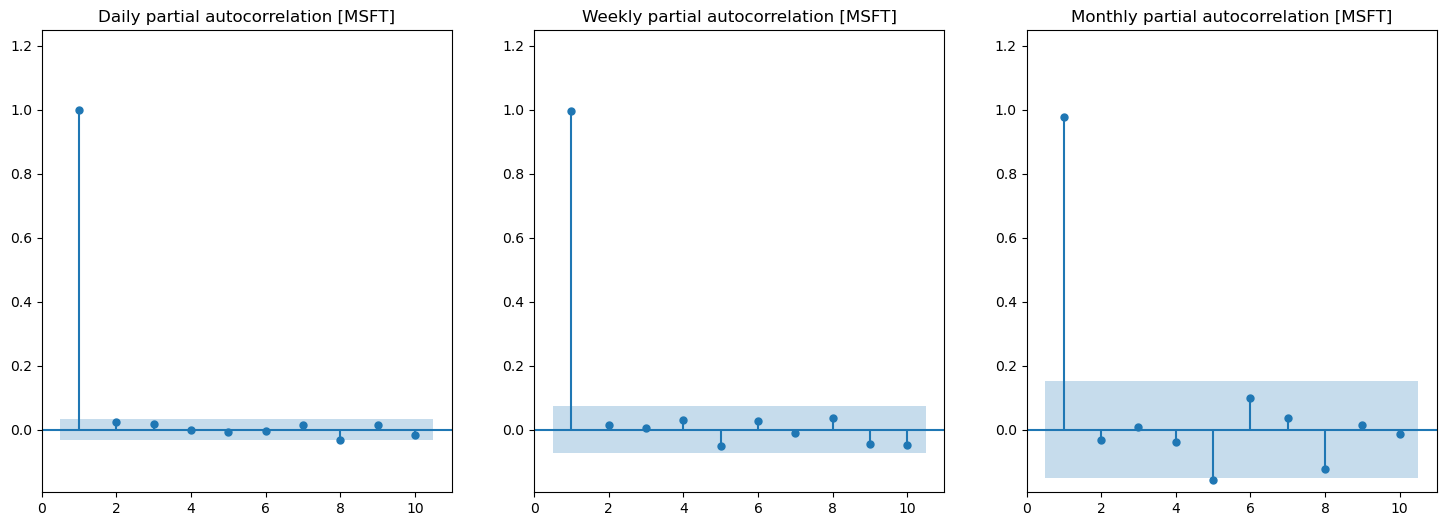

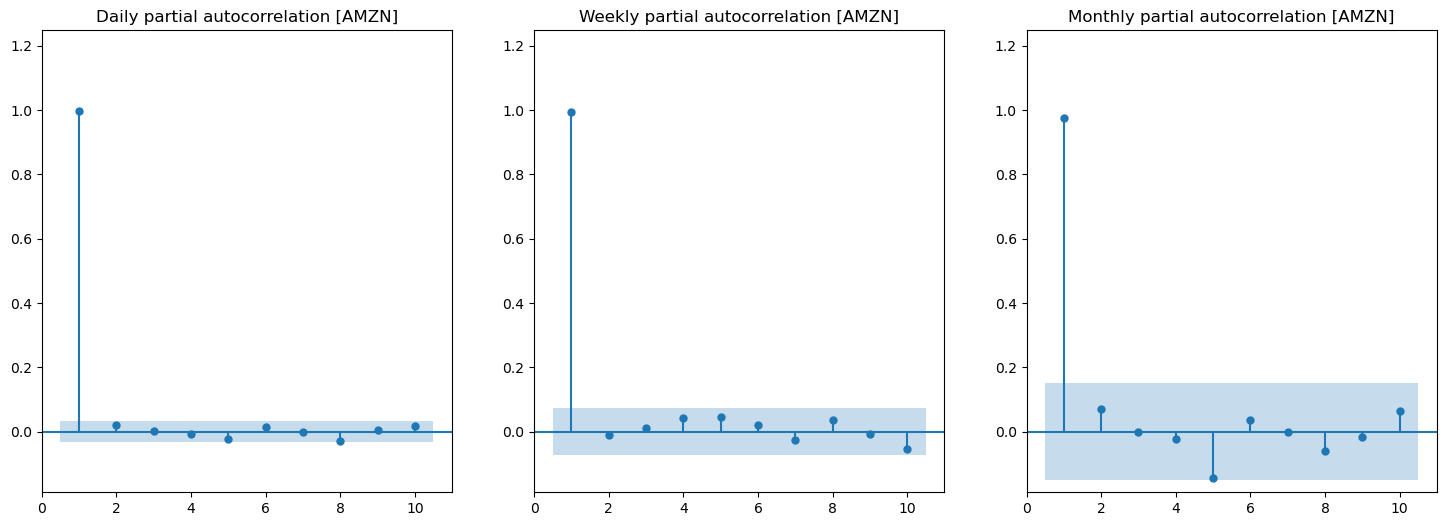

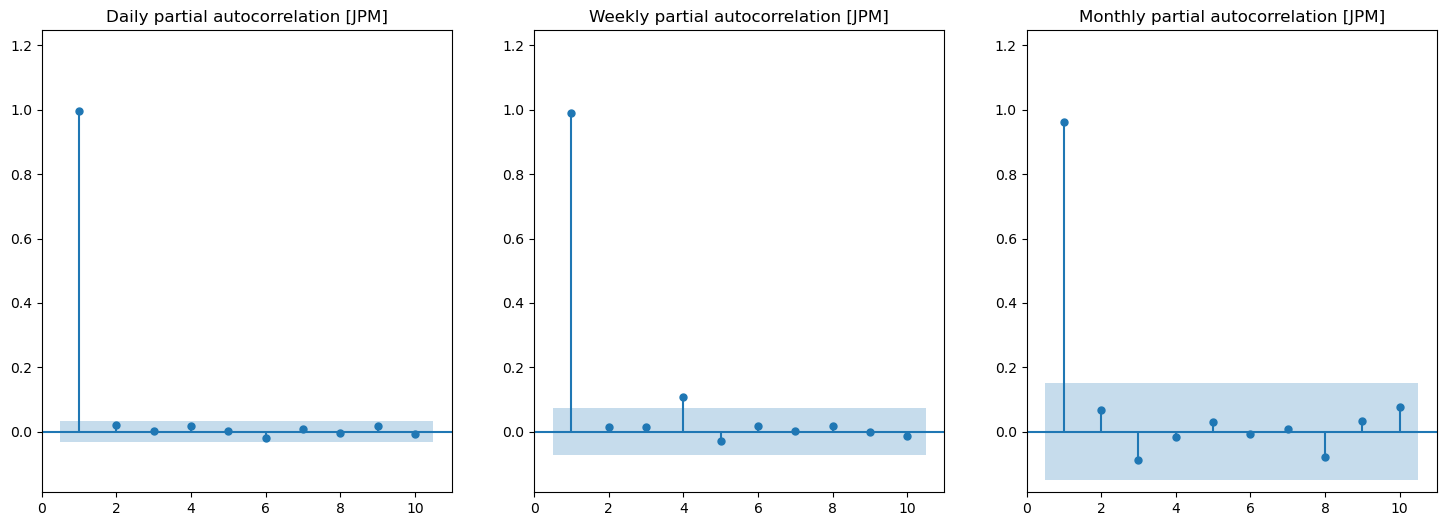

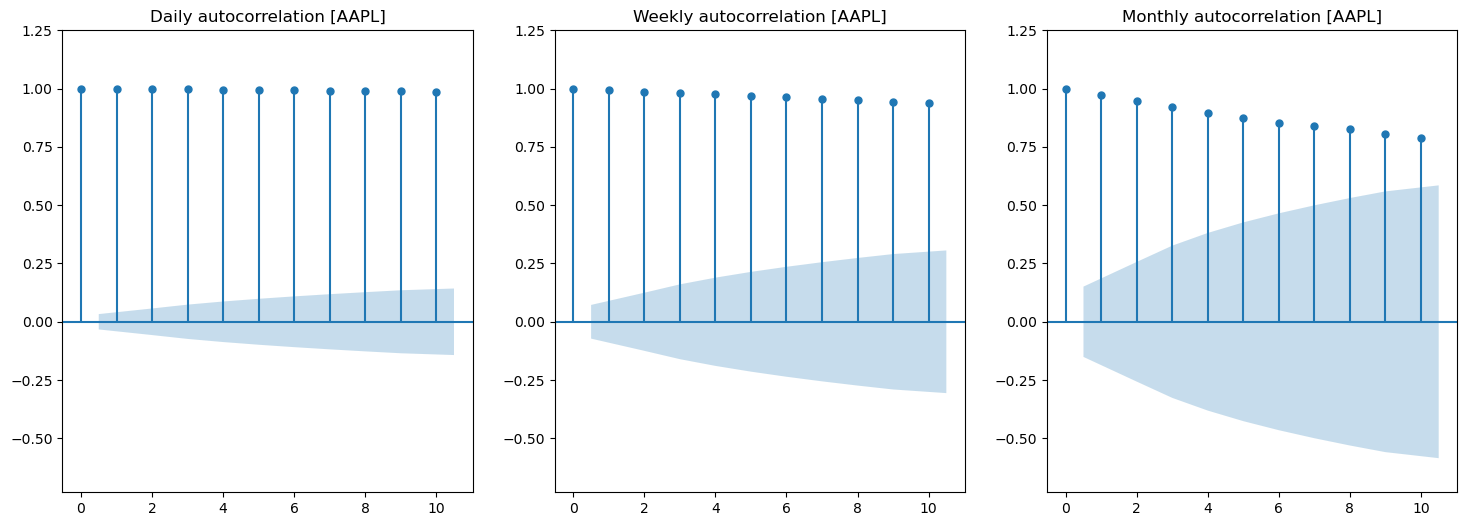

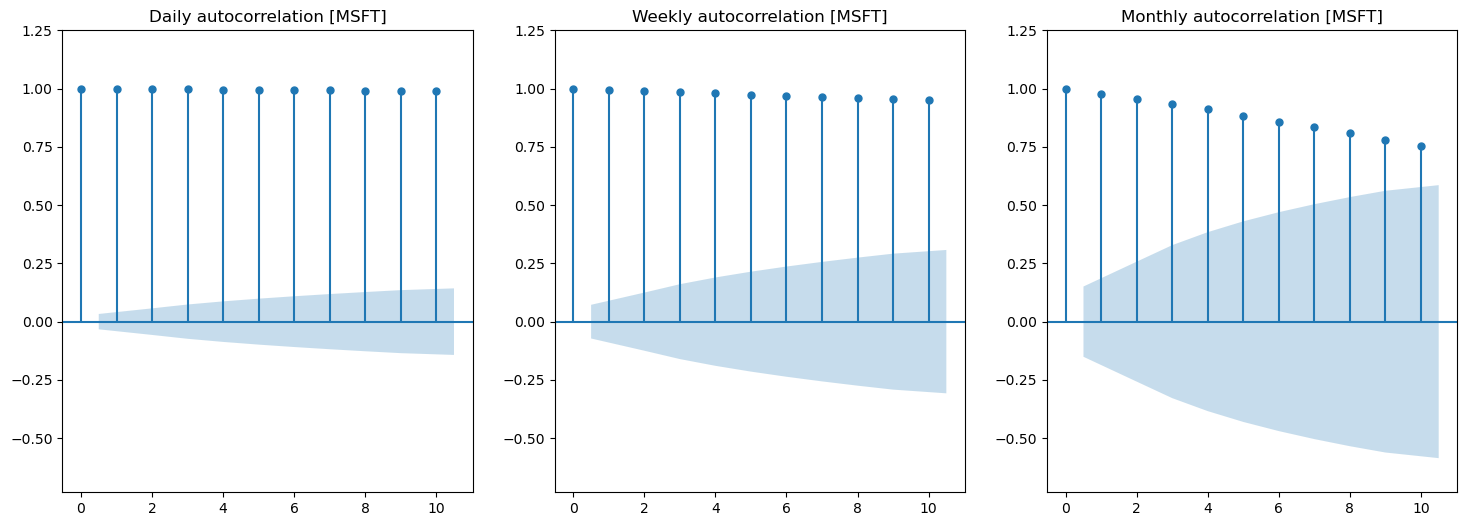

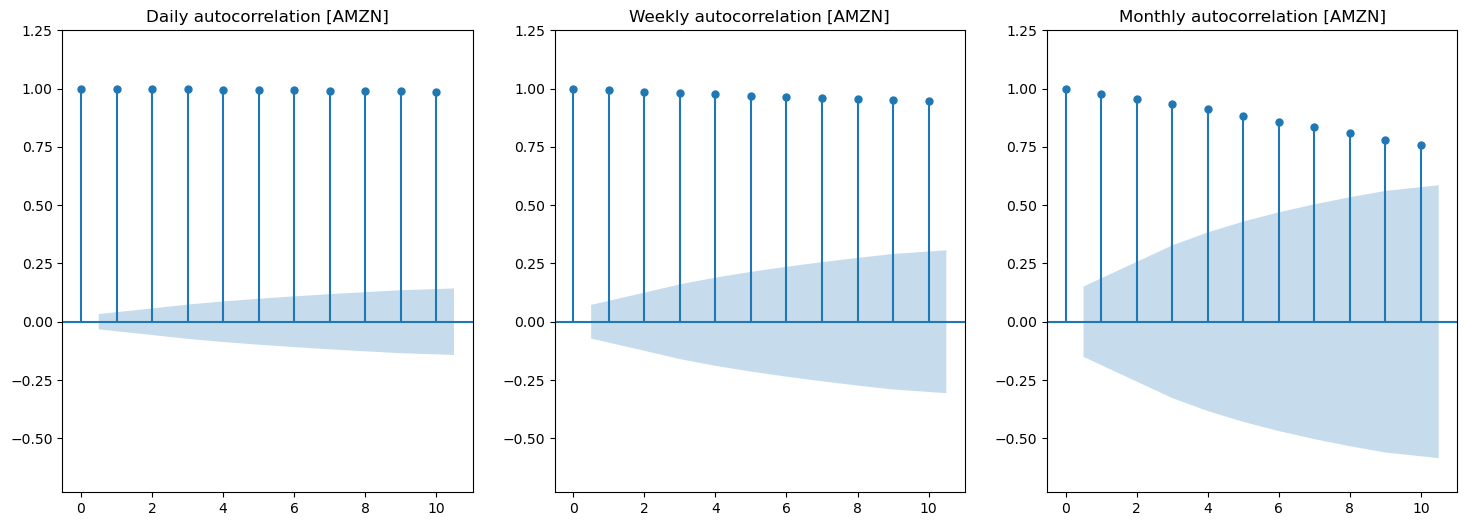

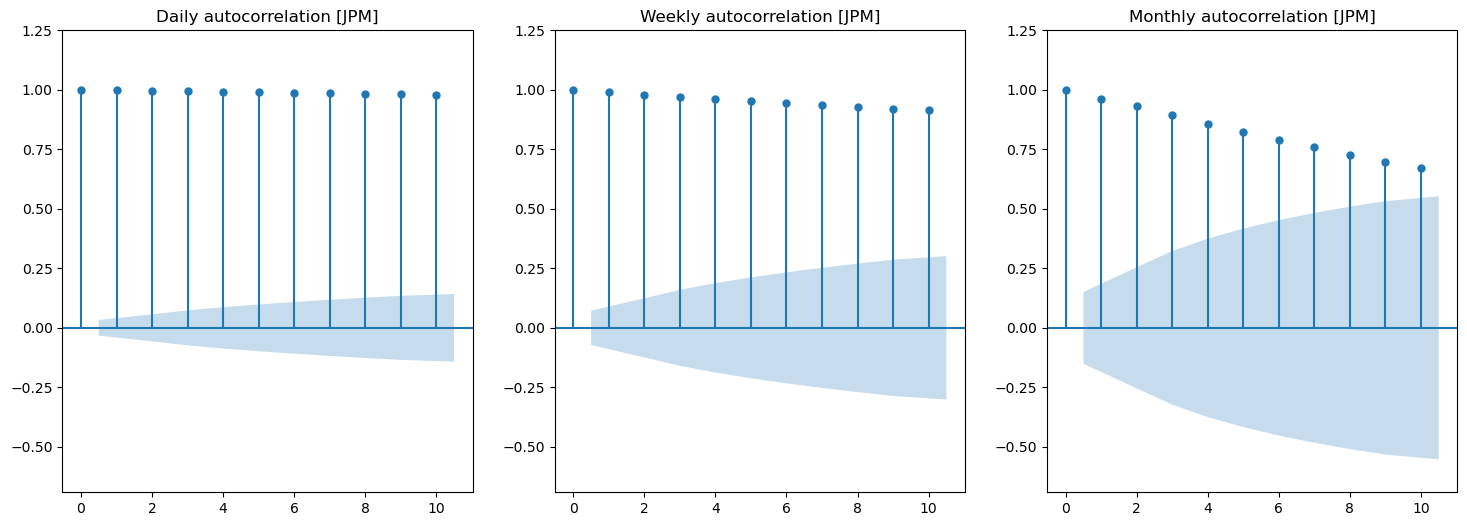

In [80]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_pacf(all_stocks[ticker], lags=10, title="Daily partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[0])
    plot_pacf(all_stocks_weekly[ticker], lags=10, title="Weekly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[1])
    plot_pacf(all_stocks_monthly[ticker], lags=10, title="Monthly partial autocorrelation [" + ticker + "]", auto_ylims=True, zero=False, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)
    
plt.close()

# Calcolo l'autocorrelazione dei rendimenti
for ticker in tickers:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    plot_acf(all_stocks[ticker], lags=10, title="Daily autocorrelation [" + ticker + "]", auto_ylims=True, zero=True, ax=axes[0])
    plot_acf(all_stocks_weekly[ticker], lags=10, title="Weekly autocorrelation [" + ticker + "]", auto_ylims=True, zero=True, ax=axes[1])
    plot_acf(all_stocks_monthly[ticker], lags=10, title="Monthly autocorrelation [" + ticker + "]", auto_ylims=True, zero=True, ax=axes[2])
    max_y = max(max(ax.get_ylim()) for ax in axes)  
    min_y = min(min(ax.get_ylim()) for ax in axes)
    for ax in axes:
        ax.set_ylim(min_y, max_y)

plt.close()